# Predict Student Grade in Online Class for Early Intervention
## By: Team 240 - Stanford Open Datathon 2021

*  [1. Introduction](#introduction)
> * 1.1 Acknowledgements

*  [2. Import libraries](#import-libraries)

* [3. Data overview](#data-overview)
> * [3.1. Assessments info](#ass)
     * 3.1.1. Missing values and duplicate rows
     * 3.1.2. Data types
     * 3.1.3. Inconsistent weights
         * 3.1.3.1. Fix inconsistent weights
     * 3.1.4. Check if Assessments Info is the in Results table
> * [3.2. Assessments results](#results)
    * 3.2.1. Missing values and duplicate rows
    * 3.2.2. Data types
    * 3.2.3. Non-submissions
> * [3.3. Courses info](#courses)
    * 3.3.1. Missing values and duplicate rows
    * 3.3.2. Data types
> * [3.4. Student registration](#reg)
    * 3.4.1. Missing values and duplicate rows
    * 3.4.2. Data types
    * 3.4.3. Check if in results table
> * [3.5. VLE resources](#vle)
    * 3.5.1. Missing values and duplicate rows
    * 3.5.2. Data types
> * [3.6. VLE Interactions](#vle-int)
    * 3.6.1. Missing values and duplicate rows
    * 3.6.2. Data types
> * [3.7. Student information](#info)
    * 3.7.1. Missing values and duplicate rows
    * 3.7.2. Data types

* [4. Exploratory Data Analysis](#eda)

* [5. Frame the problem](#frame)

* [6. Merge tables and Feature engineering](#merge)
> * 6.1. VLE + VLE Interactions
    * 6.1.1. Pre-prosessing
> * 6.2. Registration info + Courses + Info
> * 6.3. Assessment info + Assessment Results
    * 6.3.1. Feature engineering
        * 6.3.1.2. Late Submission
        * 6.3.1.3. Fail rate
    * 6.3.2. Merged all result tables
> * 6.4. Merge all tables

* [7. Split the dataset](#split)

* [8. Final cleaning](#final-cleaning)

* [9. Univariate analysis: numerical data](#num)

* [10. Univariate analysis: categorical data](#cat)

* [11. Bivariate analysis: final scores vs other variables](#scores-vs-variables)

* [12. Classification](#classification)
   > * 12.1. Model preparation
   > * 12.2. Models
   > * 12.3. Best Classification Model - evaluation

* [13. Discussion](#discussion)

<a id="introduction"></a>
# 1. Introduction
***

The dataset for this machine learning project has been provided by the learning analytics research group at the Knowledge Media institute, The Open University. The dataset is publicly available and consists of tables with information on student demographics, modules undertaken, time of year the modules start (module presentations), and information on student academic success in terms of grades for assignments and exams, as well as students’ interactions with the university’s Virtual Learning Environment (VLE).

The task at hand is to predict which students are to fail or withdraw and which are to pass their modules.

The dataset is rather messy, with many values missing and some inconsistencies between tables. All cleaning steps are detailed in the first part of the notebook. Various inconsistencies are reported and dealt with or suggestions are made as to how to deal with them in future work.

Some feature engineering is done with suggestions for more features that could be of help in this project.

Finally, several classification and regression models are used to predict student academic success.

## 1.1. Acknowledgements

Three notebooks were very helpful in starting this analysis:
* [Student Failure| Modelling with a messy dataset by Sanya Prusaka](https://www.kaggle.com/sashatarakanova/student-failure-modelling-with-a-messy-dataset)
* [Student Performance Prediction: Complete analysis by Victor Régis](https://www.kaggle.com/devassaxd/student-performance-prediction-complete-analysis)
* [Data Cleaning-Feature Generation-EDA-Segmentation by Anil](https://www.kaggle.com/anlgrbz/data-cleaning-feature-generation-eda-segmentation)

Some of the code is adapted from these notebooks

<a id="import-libraries"></a>
# 2. Import libraries
***

In [1]:
import random
import numpy as np
import pandas as pd
from plotnine import *
import plotnine
#plotnine.options.figure_size = (4.2,2.2)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import make_column_transformer
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting random seed for notebook reproducability


seed = 42
random.seed(seed)
np.random.seed(seed)

<a id="data-overview"></a>
# 3. Data overview
***

This chapter presents a quick overview of the data before the training/test split.

In [3]:
# load datasets
ass = pd.read_csv('anonymisedData/assessments.csv')
courses = pd.read_csv('anonymisedData/courses.csv')
results = pd.read_csv('anonymisedData/studentAssessment.csv')
info = pd.read_csv('anonymisedData/studentInfo.csv')
reg = pd.read_csv('anonymisedData/studentRegistration.csv')
vle = pd.read_csv('anonymisedData/studentVle.csv')
materials = pd.read_csv('anonymisedData/vle.csv')

<a id="ass"></a>
## 3.1. Assessments info

This file contains information about assessments in module-presentations. Usually, every
presentation has a number of assessments followed by the final exam. CSV contains columns:
1. **code_module** – identification code of the module, to which the assessment belongs.
2. **code_presentation** - identification code of the presentation, to which the assessment
belongs.
3. **id_assessment** – identification number of the assessment.
4. **assessment_type** – type of assessment. Three types of assessments exist: Tutor
Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam
(Exam).
5. **date** – information about the final submission date of the assessment calculated as
the number of days since the start of the module-presentation. The starting date of
the presentation has number 0 (zero).
6. **weight** - weight of the assessment in %. Typically, Exams are treated separately and
have the weight 100%; the sum of all other assessments is 100%.
If the information about the final exam date is missing, it is at the end of the last presentation
week.

In [4]:
ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### 3.1.1. Missing values and duplicate rows

In [5]:
# Percentage of missing values
ass.isnull().sum() * 100 / len(ass)

code_module          0.000000
code_presentation    0.000000
id_assessment        0.000000
assessment_type      0.000000
date                 5.339806
weight               0.000000
dtype: float64

In [6]:
ass.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64

In [7]:
ass[ass.duplicated()]

,code_module,code_presentation,id_assessment,assessment_type,date,weight


### 3.1.2. Data types

In [8]:
ass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


Assessments IDs are denoted as integers. This is incorrect - IDs by definition are categorical. Below code corrects this.

In [9]:
ass['id_assessment'] = ass['id_assessment'].astype(object)

### 3.1.3. Inconsistent weights

Project brief states that typically, exams have a weight of 100 and the sum of all other assessments is 100. This would man that a module with one exam only would have a weight of 100 and a module with one exam and some assessments would have a weight of 200. Let’s check if this so in the table provided.

In [10]:
# Group by module presentation and sum the weights of assessments
ass\
.groupby(['code_module','code_presentation'])\
.agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

Here we can see most that module presentations have total weight of 200, apart from module CCC which is 300 and module GGG which is 100. Let's have a closer look.

In [11]:
# See what are the weights of exams in module presentations
ass[ass['assessment_type'] == 'Exam']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation assessment_type              
AAA         2013J             Exam                    100.0
            2014J             Exam                    100.0
BBB         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
CCC         2014B             Exam                    200.0
            2014J             Exam                    200.0
DDD         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
EEE         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
FFF         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
GGG         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0

All modules show weight of 100 for exams apart from module CCC (for both presentations). Let's count the exams in each module presentation.

In [12]:
# Count how many exams there are in every module presentation
ass[ass['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']]\
.groupby(['code_module', 'code_presentation'])\
.count()

id_assessment
code_module code_presentation               
AAA         2013J                          1
            2014J                          1
BBB         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
CCC         2014B                          2
            2014J                          2
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
EEE         2013J                          1
            2014B                          1
            2014J                          1
FFF         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
GGG         2013J                          1
            2014B                          1
            2014J                          1

Module CCC has two exams, this can explain the hight assessments weight for this module. Now let's have a look at all the assignments that are not exams and see if everything is as it should be.

In [13]:
# Sum the weights of all course work assignments per module presentation
ass[ass['assessment_type'] != 'Exam']\
.groupby(['code_module', 'code_presentation'])\
.agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     100.0
            2014J                     100.0
BBB         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
CCC         2014B                     100.0
            2014J                     100.0
DDD         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
EEE         2013J                     100.0
            2014B                     100.0
            2014J                     100.0
FFF         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
GGG         2013J                       0.0
            2014B                       0.0
            2014J                       0.0

Here we see that module GGG doesn't have any weight to its assignments. Is it because there's no assingments for this module?

In [14]:
ass[ass['code_module'] == 'GGG']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(weight_by_type = ('weight', sum))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0

Are there any other CMA and TMA assignments with a weight of 0?

In [15]:
ass[(ass['assessment_type'] == 'CMA') & (ass['weight'] == 0) & (ass['code_module'] != 'GGG')]['weight'].count()

28

In [16]:
ass[(ass['assessment_type'] == 'TMA') & (ass['weight'] == 0) & (ass['code_module'] != 'GGG')]['weight'].count()

1

In [17]:
ass[(ass['assessment_type'] == 'TMA') & (ass['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
48,BBB,2014J,15020,TMA,19.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
192,GGG,2014B,37425,TMA,61.0,0.0
193,GGG,2014B,37426,TMA,117.0,0.0
194,GGG,2014B,37427,TMA,166.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [18]:
ass[ass['code_module'] == 'BBB']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(weight_by_type = ('weight',sum))

weight_by_type
code_module code_presentation assessment_type                
BBB         2013B             CMA                         5.0
                              Exam                      100.0
                              TMA                        95.0
            2013J             CMA                         5.0
                              Exam                      100.0
                              TMA                        95.0
            2014B             CMA                         5.0
                              Exam                      100.0
                              TMA                        95.0
            2014J             Exam                      100.0
                              TMA                       100.0

#### 3.1.3.1. Fix inconsistent weights

What is the usual weight of assignments?

In [19]:
column = ass[(ass['assessment_type'] == 'CMA') & (ass['code_module'] != 'GGG')]['weight']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

{0.0: 28, 1.0: 15, 2.0: 3, 3.0: 3, 4.0: 2, 6.0: 1, 7.0: 2, 8.0: 4}

In [20]:
column = ass[(ass['assessment_type'] == 'TMA') & (ass['code_module'] != 'GGG')]['weight']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

{0.0: 1,
 5.0: 4,
 7.5: 1,
 9.0: 2,
 10.0: 8,
 12.5: 11,
 15.0: 3,
 16.0: 3,
 17.5: 2,
 18.0: 15,
 20.0: 13,
 22.0: 6,
 25.0: 15,
 28.0: 9,
 30.0: 2,
 35.0: 2}

In [21]:
# How many total assignments in GGG module are there?
ass[ass['code_module'] == 'GGG'][['code_module', 'code_presentation', 'assessment_type', 'id_assessment']]\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.count()

id_assessment
code_module code_presentation assessment_type               
GGG         2013J             CMA                          6
                              Exam                         1
                              TMA                          3
            2014B             CMA                          6
                              Exam                         1
                              TMA                          3
            2014J             CMA                          6
                              Exam                         1
                              TMA                          3

Since CMA assignment is often weight 0, we will just assign 100 total weight to TMA assignment for simplicity.

In [22]:
# Assign new weights to module GGG assessments
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='TMA'),'weight'] = (100/3)
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='CMA'),'weight'] = (0)

In [23]:
# Check that TMA now sums to 100
ass[ass['code_module'] == 'GGG']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(weight_by_type = ('weight', sum))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0

In [24]:
# check that all assessments now sum to 200
ass[ass['code_module'] == 'GGG']\
.groupby(['code_module','code_presentation'])\
.agg(total_weight = ('weight', sum))

total_weight
code_module code_presentation              
GGG         2013J                     200.0
            2014B                     200.0
            2014J                     200.0

### 3.1.4. Check if Assessments Info is the in Results table

In [25]:
def compareCols(df1, df2):
    '''
    Check what columns are shared between two dataframes
    and count values of df1 present and absent in df2 (in the shared
    columns)
    '''

    # Show shared columns between dataframes
    # (a) Make lists of columns for each data frame
    df1Columns = df1.columns.values.tolist()
    df2Columns = df2.columns.values.tolist()

    # (b) Find column names that are the same
    diffDict = set(df1Columns) & set(df2Columns)
    
    print('Shared columns : ', diffDict, '\n')

    # (c) Make a list of the dictinary
    diffList = list(diffDict)
    # (d) Check that if values in
    # every shared column match in
    # the two dataframes
    for col in diffList:
        x = df1[col].isin(df2[col]).value_counts()
        print('Check if values are present in both dataframes:')
        print(x, '\n')

compareCols(ass, results)

Shared columns :  {'id_assessment'} 

Check if values are present in both dataframes:
True     188
False     18
Name: id_assessment, dtype: int64 



In [26]:
def findDiffValues(df1, df2, col):
    '''
    Find all df1.col values not present in df2.col
    '''
    # Pull out all unique values of col
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Compare the two lists
    # (a) Find what values are different
    diff = set(df1_IDs).difference(set(df2_IDs))
    # (b) Count how many are different
    numberDiff = len(diff)

    print("Values from df1 not in df2: " + str(diff))
    print("Number of missing values: " + str(numberDiff))

findDiffValues(ass, results, 'id_assessment')

Values from df1 not in df2: {30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911}
Number of missing values: 18


In [27]:
def printDiffValues(df1, df2, col):
    '''
    Show all df1.col values not present in df2.col
    '''
    # Pull out all unique values id_assessments
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Compare the two lists
    # (a) Find what values are different
    diff = set(df1_IDs).difference(set(df2_IDs))
    
    # Show information for all df1.col values not presentin df2.col
    # (a) Make a list of missing values
    missingList = list(diff)
    # (b) Find these IDs in df2
    missingDf = df1[df1[col].isin(missingList)]

    return missingDf

printDiffValues(ass, results, 'id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0
113,EEE,2013J,30713,Exam,235.0,100.0
118,EEE,2014B,30718,Exam,228.0,100.0


All assignments missing from the Results (and consequently Merged) table are exams with 100% module weight. Are there any other 100% weighted assignments in the Assessment table apart from these?

In [28]:
# Make a list of missing IDs
missingList = [30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911]

# Get all rows with weight 100 from Assessments table
weight100 = ass[ass['weight'] == 100]
# Get all unique assessment IDs
weight100List = weight100['id_assessment'].unique()

# Compare this list with the list of all assessment IDs missing from results table
compare = set(weight100List).difference(set(missingList))
numberCompare = len(compare)

print("100 weighted assessments in the Results table (that are not missing exams): " + str(compare))
print("Number of 100 weighted assessments (that are not missing exams) in the Results table: " + str(numberCompare))

100 weighted assessments in the Results table (that are not missing exams): {24290, 25354, 24299, 25361, 25368, 25340}
Number of 100 weighted assessments (that are not missing exams) in the Results table: 6


In [29]:
# Show information for weight 100 assessments in the results table
# (a) Make a list of IDs to look for
matchList = [24290, 25354, 24299, 25361, 25368, 25340]
# (b) Find these IDs in the Assessments table
matchDf = ass[ass['id_assessment'].isin(matchList)]

matchDf

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
108,DDD,2014J,25368,Exam,NaN,100.0


Due to the above we can't say that all final exams are missing from the results table, just some exams.

<a id="results"></a>
## 3.2. Assessments results

This file contains the results of students’ assessments. If the student does not submit the
assessment, no result is recorded. The final exam submissions is missing, if the result of the
assessments is not stored in the system. This file contains the following columns:
1. **id_assessment** – the identification number of the assessment.
2. **id_student** – a unique identification number for the student.
3. **date_submitted** – the date of student submission, measured as the number of days
since the start of the module presentation.
4. **is_banked** – a status flag indicating that the assessment result has been transferred
from a previous presentation.
5. **score** – the student’s score in this assessment. The range is from 0 to 100. The score
lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [30]:
results.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


### 3.2.1. Missing values and duplicate rows

In [31]:
# Percentage of missing values
results.isnull().sum() * 100 / len(results)

id_assessment     0.000000
id_student        0.000000
date_submitted    0.000000
is_banked         0.000000
score             0.099476
dtype: float64

In [32]:
results.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

We can see that the number of assessments in the results table does not match the number of assessments in the Assessments table.

In [33]:
results[results.duplicated()]

,id_assessment,id_student,date_submitted,is_banked,score


### 3.2.2. Data types

In [34]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [35]:
results['id_assessment'] = results['id_assessment'].astype(object)
results['id_student'] = results['id_student'].astype(object)

### 3.2.3. Non-submissions

We know that if the student does not submit the assessment, no result is recorded. Therefore, all null scores can be interpreted as non-submissions. This means we can fill them out with zeros.

It is, however, a little strange that there are recorded submission days for assessments with null scores. One would expect a null value for the submission date for an assessment that has not been submitted. Ideally, this should be clarified with data providers.

In [36]:
# Have a look at NaN values
results[results['score'].isnull()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


In [37]:
# Replace all null values with 0s
results.fillna(0, inplace=True)

<a id="courses"></a>
## 3.3. Courses info

File contains the list of all available modules and their details. The columns are:
1. **code_module** – code name of the module, which serves as the identifier.
2. **code_presentation** – code name of the presentation. It consists of the year and “B” for
the presentation starting in February and “J” for the presentation starting in October.
3. **length** - length of the module-presentation in days.

In [38]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


### 3.3.1. Missing values and duplicate rows

In [39]:
# Percentage of missing values
courses.isnull().sum() * 100 / len(courses)

code_module                   0.0
code_presentation             0.0
module_presentation_length    0.0
dtype: float64

In [40]:
courses.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

In [41]:
courses[courses.duplicated()]

,code_module,code_presentation,module_presentation_length


### 3.3.2. Data types

In [42]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


<a id="reg"></a>
## 3.4. Student registration

This file contains information about the time when the student registered for the module
presentation. For students who unregistered the date of unregistration is also recorded. File
contains five columns:
1. **code_module** – an identification code for a module.
2. **code_presentation** - the identification code of the presentation.
3. **id_student** – a unique identification number for the student.
4. **date_registration** – the date of student’s registration on the module presentation, this
is the number of days measured relative to the start of the module-presentation (e.g.
the negative value -30 means that the student registered to module presentation 30
days before it started).
5. **date_unregistration** – date of student un-registration from the module presentation,
this is the number of days measured relative to the start of the module-presentation.
Students, who completed the course have this field empty. Students who unregistered
have Withdrawal as the value of the final_result column in the studentInfo.csv file.

In [43]:
reg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


### 3.4.1. Missing values and duplicate rows

In [44]:
# Percentage of missing values
reg.isnull().sum() * 100 / len(reg)

code_module             0.000000
code_presentation       0.000000
id_student              0.000000
date_registration       0.138066
date_unregistration    69.097659
dtype: float64

In [45]:
reg.nunique()

code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64

In [46]:
reg[reg.duplicated()]

,code_module,code_presentation,id_student,date_registration,date_unregistration


### 3.4.2. Data types

In [47]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [48]:
reg['id_student'] = reg['id_student'].astype(object)

### 3.4.3. Check if in Results table

Check if all student IDs recorded in the Registration tables are recorded in the Results table.

In [49]:
compareCols(reg, results)

Shared columns :  {'id_student'} 

Check if values are present in both dataframes:
True     26746
False     5847
Name: id_student, dtype: int64 



There are 5847 students missing from the Results table. Are there any students from the Student Information table missing from the Results table?

In [50]:
compareCols(info, results)

Shared columns :  {'id_student'} 

Check if values are present in both dataframes:
True     26746
False     5847
Name: id_student, dtype: int64 



Yes, there are also 5847 students recorded in the Students Information table missing from the Assessment Results table. Are these the same students?

In [51]:
# Pull out all unique values id_assessments
df1_IDs = reg['id_student'].unique()
df2_IDs = info['id_student'].unique()

# Compare the two lists
# (a) Find what assessment IDs are different
diff = set(df1_IDs).difference(set(df2_IDs))
# (b) Count how many are different
numberDiff = len(diff)

numberDiff

0

In [52]:
compareCols(reg, info)

Shared columns :  {'code_presentation', 'code_module', 'id_student'} 

Check if values are present in both dataframes:
True    32593
Name: code_presentation, dtype: int64 

Check if values are present in both dataframes:
True    32593
Name: code_module, dtype: int64 

Check if values are present in both dataframes:
True    32593
Name: id_student, dtype: int64 



Yes, these are the same students. Let's have a closer look.

In [53]:
info_not_in_results = printDiffValues(info, results, 'id_student')
info_not_in_results.head(10)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
44,AAA,2013J,135335,F,East Anglian Region,Lower Than A Level,20-30%,0-35,0,180,N,Withdrawn
118,AAA,2013J,281589,M,North Western Region,HE Qualification,30-40%,0-35,0,60,N,Fail
125,AAA,2013J,292923,F,South East Region,A Level or Equivalent,90-100%,35-55,0,180,N,Withdrawn
136,AAA,2013J,305539,F,Wales,Lower Than A Level,80-90%,0-35,0,120,N,Withdrawn
169,AAA,2013J,346843,F,Scotland,HE Qualification,50-60%,35-55,0,120,N,Fail
171,AAA,2013J,354858,M,South Region,HE Qualification,90-100%,35-55,0,120,N,Withdrawn
198,AAA,2013J,405961,M,Scotland,A Level or Equivalent,90-100%,0-35,0,240,Y,Withdrawn
209,AAA,2013J,494424,F,North Region,A Level or Equivalent,80-90%,0-35,0,60,N,Fail
256,AAA,2013J,1763015,F,Scotland,A Level or Equivalent,10-20,35-55,0,60,N,Withdrawn


In [54]:
# What are their final results?
column = info_not_in_results['final_result']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

{'Fail': 1197, 'Pass': 2, 'Withdrawn': 4648}

The brief stated that assignments not recorded in the Results table and not recorded due to the student not submitting them. However, here we have 2 students with no submissions recorded who have passed their modules. This may be due to two reasons:
* The recorded pass is a clerical error.
* The brief is wrong.

In [55]:
reg_not_in_results = printDiffValues(reg, results, 'id_student')
reg_not_in_results.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration
2,AAA,2013J,30268,-92.0,12.0
44,AAA,2013J,135335,-29.0,30.0
118,AAA,2013J,281589,-50.0,NaN
125,AAA,2013J,292923,-162.0,-121.0
136,AAA,2013J,305539,-54.0,-3.0
169,AAA,2013J,346843,-44.0,NaN
171,AAA,2013J,354858,-32.0,5.0
198,AAA,2013J,405961,-170.0,-100.0
209,AAA,2013J,494424,-38.0,NaN
256,AAA,2013J,1763015,-58.0,-2.0


In [56]:
# What are their unregistration status?
reg_not_in_results['date_unregistration'].notnull().sum()

4594

Here, again, we see an inconsistency as all withdrawn students should have their date_unregistration field filled in. According to the Student Information table 4648 students have withdrawn, however, according to the Registration table 4594 students have unregistered. This leaves 54 withdrawn students without an unregistration date.

Let's check unregistration dates for 2 students with passes that have no recorded assessment results. If we find unregistration dates for these students we'll know it's a clerical error.

In [57]:
# Show rows with passes
info_not_in_results[info_not_in_results['final_result'] == 'Pass']

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
645,AAA,2014J,1336190,M,London Region,HE Qualification,80-90%,55<=,0,60,N,Pass
12893,CCC,2014J,1777834,F,East Anglian Region,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


In [58]:
# Find their date unregistration
reg_not_in_results[reg_not_in_results['id_student'] == 1336190]

,code_module,code_presentation,id_student,date_registration,date_unregistration
645,AAA,2014J,1336190,-23.0,NaN


In [59]:
reg_not_in_results[reg_not_in_results['id_student'] == 1777834]

,code_module,code_presentation,id_student,date_registration,date_unregistration
12893,CCC,2014J,1777834,NaN,NaN


There are no unregistration dates for these 2 students, however, we know there are 54 withdrawn students that have no unregistration dates, so it's unclear how much we can trust this data.

<a id="vle"></a>
## 3.5. VLE resources

The csv file contains information about the available materials in the VLE. Typically, these are
html pages, pdf files, etc. Students have access to these materials online and their interactions
with the materials are recorded. The table comprises of the following columns:
1. **id_site** – an identification number of the material.
2. **code_module** – an identification code for module.
3. **code_presentation** - the identification code of presentation.
4. **activity_type** – the role associated with the module material.
5. **week_from** – the week from which the material is planned to be used.
6. **week_to** – week until which the material is planned to be used.

In [60]:
materials.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### 3.5.1. Missing values and duplicate rows

In [61]:
# Percentage of missing values
materials.isnull().sum() * 100 / len(materials)

id_site               0.000000
code_module           0.000000
code_presentation     0.000000
activity_type         0.000000
week_from            82.385292
week_to              82.385292
dtype: float64

In [62]:
materials.nunique()

id_site              6364
code_module             7
code_presentation       4
activity_type          20
week_from              30
week_to                30
dtype: int64

In [63]:
materials[materials.duplicated()]

,id_site,code_module,code_presentation,activity_type,week_from,week_to


### 3.5.2. Data types

In [64]:
materials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [65]:
materials['id_site'] = materials['id_site'].astype(object)

<a id="vle-int"></a>
## 3.6. VLE Interactions

The studentVle.csv file contains information about each student’s interactions with the
materials in the VLE. This file contains the following columns:
1. **code_module** – an identification code for a module.
2. **code_presentation** - the identification code of the module presentation.
3. **id_student** – a unique identification number for the student.
4. **id_site** - an identification number for the VLE material.
5. **date** – the date of student’s interaction with the material measured as the number of
days since the start of the module-presentation.
6. **sum_click** – the number of times a student interacts with the material in that day.

In [66]:
vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400.0,546652.0,-10.0,4.0
1,AAA,2013J,28400.0,546652.0,-10.0,1.0
2,AAA,2013J,28400.0,546652.0,-10.0,1.0
3,AAA,2013J,28400.0,546614.0,-10.0,11.0
4,AAA,2013J,28400.0,546714.0,-10.0,1.0


### 3.6.1. Missing values and duplicate rows

In [67]:
# Percentage of missing values
vle.isnull().sum() * 100 / len(vle)

code_module          0.000000
code_presentation    0.000009
id_student           0.000009
id_site              0.000009
date                 0.000009
sum_click            0.000009
dtype: float64

In [68]:
vle.nunique()

code_module              8
code_presentation        4
id_student           26074
id_site               6268
date                   295
sum_click              498
dtype: int64

In [69]:
vle[vle.duplicated()].head()

,code_module,code_presentation,id_student,id_site,date,sum_click
2,AAA,2013J,28400.0,546652.0,-10.0,1.0
63,AAA,2013J,45462.0,546652.0,-10.0,1.0
180,AAA,2013J,77367.0,546652.0,-10.0,4.0
193,AAA,2013J,94961.0,546652.0,-10.0,2.0
442,AAA,2013J,248270.0,546652.0,-10.0,4.0


Duplication is entirely acceptable here as the system most likely records the clicks at different points on the same day, leading to duplicates.

### 3.6.2. Data types

In [70]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655281 entries, 0 to 10655280
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   code_module        object 
 1   code_presentation  object 
 2   id_student         float64
 3   id_site            float64
 4   date               float64
 5   sum_click          float64
dtypes: float64(4), object(2)
memory usage: 487.8+ MB


In [71]:
vle['id_student'] = vle['id_student'].astype(object)
vle['id_site'] = vle['id_site'].astype(object)

<a id="info"></a>
## 3.7. Student information

This file contains demographic information about the students together with their results. File
contains the following columns:
1. **code_module** – an identification code for a module on which the student is registered.
2. **code_presentation** - the identification code of the presentation during which the
student is registered on the module.
3. **id_student** – a unique identification number for the student.
4. **gender** – the student’s gender.
5. **region** – identifies the geographic region, where the student lived while taking the
module-presentation.
6. **highest_education** – highest student education level on entry to the module
presentation.
7. **imd_band** – specifies the Index of Multiple Depravation band of the place where the
student lived during the module-presentation.
8. **age_band** – band of the student’s age.
9. **num_of_prev_attempts** – the number times the student has attempted this module.
10. **studied_credits** – the total number of credits for the modules the student is currently
studying.
11. **disability** – indicates whether the student has declared a disability.
12. **final_result** – student’s final result in the module-presentation.

In [72]:
info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [73]:
info.final_result.value_counts()

Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: final_result, dtype: int64

### 3.7.1. Missing values and duplicate rows

In [74]:
info.isnull().sum() * 100 / len(info)

code_module             0.000000
code_presentation       0.000000
id_student              0.000000
gender                  0.000000
region                  0.000000
highest_education       0.000000
imd_band                3.408707
age_band                0.000000
num_of_prev_attempts    0.000000
studied_credits         0.000000
disability              0.000000
final_result            0.000000
dtype: float64

In [75]:
info.nunique()

code_module                 7
code_presentation           4
id_student              28785
gender                      2
region                     13
highest_education           5
imd_band                   10
age_band                    3
num_of_prev_attempts        7
studied_credits            61
disability                  2
final_result                4
dtype: int64

In [76]:
info[info.duplicated()]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result


### 3.7.2. Data types

In [77]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [78]:
info['id_student'] = info['id_student'].astype(object)

<a id="eda"></a>
# 4. Exploratory Data Analysis
***

In [79]:
assessments = pd.read_csv('anonymisedData/assessments.csv')
courses2 = pd.read_csv('anonymisedData/courses.csv')
studentAssessment = pd.read_csv('anonymisedData/studentAssessment.csv')
studentInfo = pd.read_csv('anonymisedData/studentInfo.csv')
studentRegistration = pd.read_csv('anonymisedData/studentRegistration.csv')
studentVle = pd.read_csv('anonymisedData/studentVle.csv')
vle2 = pd.read_csv('anonymisedData/vle.csv')

In [80]:
#data cleaning and removing missing values
assessments.dropna(inplace=True)
courses2.dropna(inplace=True)
studentAssessment.dropna(inplace=True)
studentInfo.dropna(inplace=True)
studentRegistration.dropna(inplace=True)
studentVle.dropna(inplace=True)
vle2.dropna(inplace=True)

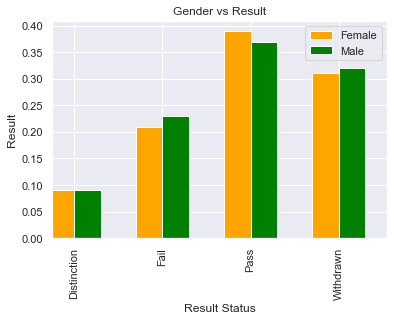

In [81]:
# Results based on Gender

gender = studentInfo.groupby(['gender'],as_index = False)
gender_count = gender['id_student'].count()
result_gender = studentInfo.groupby(['gender', 'final_result'],as_index = False)
result_gender_count = result_gender['id_student'].count()

merge = pd.merge(gender_count, result_gender_count, on = 'gender', how = 'left')
merge['i'] = round((merge['id_student_y']/merge['id_student_x']), 2)
merge = merge[['gender','final_result', 'i']]

female = merge.loc[merge['gender'] == 'F']
male = merge.loc[merge['gender'] == 'M']

fig = plt.figure() 

ax = fig.add_subplot(111) 

female.set_index('final_result',drop=True,inplace=True)
male.set_index('final_result',drop=True,inplace=True)
female.plot(kind='bar', color='orange',ax=ax, width= 0.3, position=1)
male.plot(kind='bar', color='green', ax=ax, width= 0.3, position=0)

plt.xlabel('Result Status')
plt.ylabel('Result')
plt.title('Gender vs Result')
plt.legend(['Female', 'Male'])
plt.show()


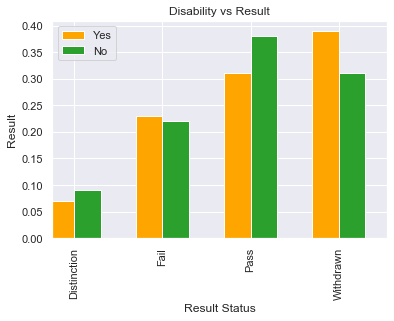

In [82]:

disability_ = studentInfo.groupby(['disability'],as_index = False)
disability_count = disability_['id_student'].count()
result_disability = studentInfo.groupby(['disability', 'final_result'],as_index = False)
result_disability_count = result_disability['id_student'].count()

merge = pd.merge(disability_count, result_disability_count, on = 'disability', how = 'left')
merge['i'] = round((merge['id_student_y']/merge['id_student_x']), 2)
merge = merge[['disability','final_result', 'i']]

yes = merge.loc[merge['disability'] == 'Y']
no = merge.loc[merge['disability'] == 'N']

fig = plt.figure() 

ax = fig.add_subplot(111) 

yes.set_index('final_result',drop=True,inplace=True)
no.set_index('final_result',drop=True,inplace=True)
yes.plot(kind='bar', color='orange',ax=ax, width= 0.3, position=1)
no.plot(kind='bar', color='#2ca02c', ax=ax, width= 0.3, position=0)

plt.xlabel('Result Status')
plt.ylabel('Result')
plt.title('Disability vs Result')
plt.legend(['Yes', 'No'])
plt.show()

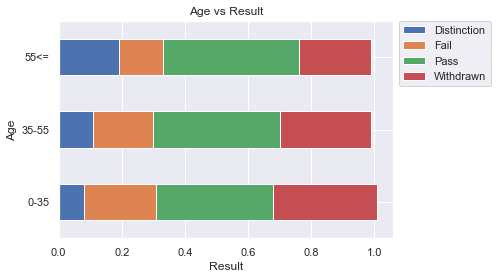

In [83]:

age = studentInfo.groupby(['age_band'],as_index = False)
age_count = age['id_student'].count()
result_age = studentInfo.groupby(['age_band', 'final_result'],as_index = False)
result_age_count = result_age['id_student'].count()

merge = pd.merge(age_count, result_age_count, on = 'age_band', how = 'left')
merge['_'] = round((merge['id_student_y']/merge['id_student_x']), 2)
merge = merge[['age_band','final_result', '_']]

merge.set_index(['age_band','final_result']).unstack().plot(kind = 'barh', stacked = True)


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.ylabel('Age')
plt.xlabel('Result')
plt.title('Age vs Result')
plt.legend(['Distinction','Fail', 'Pass', 'Withdrawn'], loc='center left', bbox_to_anchor=(1, 0.85))
plt.show()

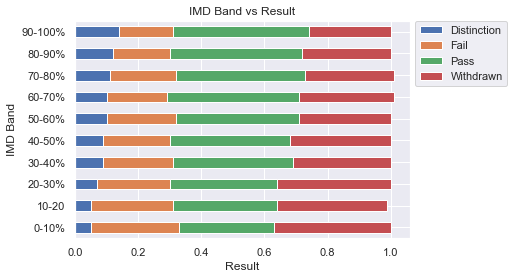

In [84]:
#Results based on IMD Band


imd = studentInfo.groupby(['imd_band'],as_index = False)
imd_count = imd['id_student'].count()
result_imd = studentInfo.groupby(['imd_band', 'final_result'],as_index = False)
result_imd_count = result_imd['id_student'].count()

merge = pd.merge(imd_count, result_imd_count , on = 'imd_band', how = 'left')
merge['_'] = round((merge['id_student_y']/merge['id_student_x']), 2)
merge = merge[['imd_band','final_result', '_']]

merge.set_index(['imd_band','final_result']).unstack().plot(kind="barh", stacked = True)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.ylabel('IMD Band')
plt.xlabel('Result')
plt.title('IMD Band vs Result')
plt.legend(['Distinction','Fail', 'Pass', 'Withdrawn'], loc='center left', bbox_to_anchor=(1, 0.85))
plt.show()

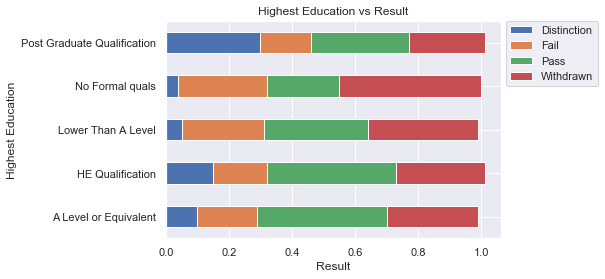

In [85]:
#Results based on Highest Education

education = studentInfo.groupby(['highest_education'],as_index = False)
education_count = education['id_student'].count()
result_education = studentInfo.groupby(['highest_education', 'final_result'],as_index = False)
result_education_count = result_education['id_student'].count()

merge = pd.merge(education_count, result_education_count , on = 'highest_education', how = 'left')
merge['_'] = round((merge['id_student_y']/merge['id_student_x']), 2)
merge = merge[['highest_education','final_result', '_']]

merge.set_index(['highest_education','final_result']).unstack().plot(kind = 'barh', stacked = True)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.ylabel('Highest Education')
plt.xlabel('Result')
plt.title('Highest Education vs Result')
plt.legend(['Distinction','Fail', 'Pass', 'Withdrawn'], loc='center left', bbox_to_anchor=(1, 0.85))
plt.show()

<a id="frame"></a>
# 5. Frame the problem
***

We can think of this work as a regression *and* a classification problem designed to predict student academic failure and student withdrawal from module presentations.

Considering the incompleteness of data, the above is tricky.

The scores in the Assessment Results table are not complete - all modules but one are missing their final exam results for all students. This means that using the table as a whole with scores as a response variable for regression can lead to less robust results as information is not complete. In other words, it is possible for a student to pass their assignments and fail their final exam resulting in overall fail for the module.

Another point is that score is the same thing as the final result (in the Student Information table), so predicting the likelihood of someone failing knowing that they got less than 40% as their final mark is not a prediction at all. And, it would be quite interesting to see if it is possible to identify students at risk of withdrawing or failing without knowing anything about their actual academic performance.

All of these points considered, this is the plan:

1. **Classification problem**: merge all tables apart from Assessment Results and use the final result column from Student Information table as target.

We can then see which models gives the best predictions.

<a id="merge"></a>
# 6. Merge tables and Feature engineering
***

###### 6.1. VLE + VLE Interactions

In [86]:
compareCols(materials, vle)

Shared columns :  {'code_presentation', 'code_module', 'id_site'} 

Check if values are present in both dataframes:
True    6364
Name: code_presentation, dtype: int64 

Check if values are present in both dataframes:
True    6364
Name: code_module, dtype: int64 

Check if values are present in both dataframes:
True     6268
False      96
Name: id_site, dtype: int64 



There are 96 entries in id_site in Materials table that are not in the VLE table.

In [87]:
findDiffValues(materials, vle, 'id_site')

Values from df1 not in df2: {674323, 674324, 527386, 527399, 1073191, 527404, 1027118, 924208, 924209, 924210, 924211, 546872, 924222, 924225, 877133, 546897, 547941, 551014, 1072236, 1072237, 1072239, 1072240, 1072252, 1072253, 551036, 547969, 527493, 1077905, 527506, 923834, 923835, 716987, 729799, 729803, 729805, 1032910, 729808, 936658, 936659, 551124, 924383, 729824, 924387, 924388, 729831, 729835, 729836, 729837, 729838, 729839, 729840, 729845, 673527, 551159, 673529, 832764, 673535, 551169, 913688, 547638, 547639, 936763, 547646, 547648, 1076553, 547663, 674130, 547668, 547682, 547684, 779622, 547689, 547692, 547693, 527224, 883074, 716675, 813957, 547718, 526733, 790925, 547733, 547742, 730034, 909241, 547771, 716221, 547782, 547278, 1071060, 547800, 526818, 1072099, 1072100, 1072098, 703977}
Number of missing values: 96


In [88]:
printDiffValues(materials, vle, 'id_site')

,id_site,code_module,code_presentation,activity_type,week_from,week_to
6,546897,AAA,2013J,url,NaN,NaN
24,546872,AAA,2013J,subpage,NaN,NaN
222,1032910,AAA,2014J,url,NaN,NaN
285,1072237,AAA,2014J,url,NaN,NaN
292,1027118,AAA,2014J,url,NaN,NaN
...,...,...,...,...,...,...
5365,779622,FFF,2014B,subpage,NaN,NaN
5442,924222,FFF,2014B,forumng,NaN,NaN
5632,1072239,FFF,2014J,forumng,NaN,NaN
5728,883074,FFF,2014J,subpage,NaN,NaN


This probbaly means these resources were not used by any students or that these resources did not record activity. And as such, we can merge these two tables with an inner merge as resources with no activity for any student provide zero information. Week_from and week_to columns can be dropped as they are over 82% empty. Drop date as it won't provide any extra information after grouping by module presentation per student.

In [89]:
# Merge with an inner join
VLEmaterials = pd.merge(vle, materials, on=['code_module', 'code_presentation', 'id_site'], how='inner')
# Drop columns
VLEmaterials.drop(columns=['week_from', 'week_to', 'date'], inplace=True)

VLEmaterials.head()

,code_module,code_presentation,id_student,id_site,sum_click,activity_type
0,AAA,2013J,28400.0,546652.0,4.0,forumng
1,AAA,2013J,28400.0,546652.0,1.0,forumng
2,AAA,2013J,28400.0,546652.0,1.0,forumng
3,AAA,2013J,28400.0,546652.0,8.0,forumng
4,AAA,2013J,30268.0,546652.0,3.0,forumng


### 6.1.1. Pre-prosessing

Get toal clicks per student per module presentation.

In [90]:
VLEmaterials\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ("sum_click",sum))

total_click
code_module code_presentation id_student             
AAA         2013J             11391.0           934.0
                              28400.0          1435.0
                              30268.0           281.0
                              31604.0          2158.0
                              32885.0          1034.0
...                                               ...
GGG         2014J             2640965.0          41.0
                              2645731.0         893.0
                              2648187.0         312.0
                              2679821.0         275.0
                              2684003.0         616.0

[29228 rows x 1 columns]

In [91]:
total_click_per_student = VLEmaterials\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ("sum_click",sum))\
.reset_index()

total_click_per_student.head(7)

,code_module,code_presentation,id_student,total_click
0,AAA,2013J,11391.0,934.0
1,AAA,2013J,28400.0,1435.0
2,AAA,2013J,30268.0,281.0
3,AAA,2013J,31604.0,2158.0
4,AAA,2013J,32885.0,1034.0
5,AAA,2013J,38053.0,2445.0
6,AAA,2013J,45462.0,1492.0


## 6.2. Registration info + Courses + Info

Date_registration may turn out to be a predictor of future fail or withdrawal as early registration may predict keen interest and future success, or in an opposite way, early registration means students become disinterested in the module by the time it starts and are likely to withdraw.

In [92]:
# Check that all module presentations in
# Registration table are present in Courses table
compareCols(reg, courses)

Shared columns :  {'code_presentation', 'code_module'} 

Check if values are present in both dataframes:
True    32593
Name: code_presentation, dtype: int64 

Check if values are present in both dataframes:
True    32593
Name: code_module, dtype: int64 



All module presentations from Registration table are present in the Courses table.

Course length may well be a good predictor of withdrawal simply due to the fact that longer courses will have more time for students to decide to drop out.

In [93]:
# Have a look at all unique module lengths
courses['module_presentation_length'].unique()

array([268, 269, 262, 240, 234, 241, 261])

The lengths of modules are not drastically different, but it might make an impact.

In [94]:
# Merge with an inner join
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')

regCourses.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,268
1,AAA,2013J,28400,-53.0,NaN,268
2,AAA,2013J,30268,-92.0,12.0,268
3,AAA,2013J,31604,-52.0,NaN,268
4,AAA,2013J,32885,-176.0,NaN,268


In [95]:
# Merge with an inner join
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

regCoursesInfo.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


## 6.3. Assessment info + Assessment Results

Assessment information table will provide just that - information on weights for assessmtn scores.

In [96]:
# merge with an inner join
assResults = pd.merge(ass, results, on=['id_assessment'], how='inner')
# Rearrange column names
assResults = assResults[['id_student', 'code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'date_submitted', 'weight', 'is_banked', 'score']]

assResults.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0


In [97]:
assResults.isnull().sum()

id_student              0
code_module             0
code_presentation       0
id_assessment           0
assessment_type         0
date                 2865
date_submitted          0
weight                  0
is_banked               0
score                   0
dtype: int64

Note that there are null values.

### 6.3.1. Feature engineering

#### 6.3.1.1. Weighted score

**How it will be calculated:**

To calculate the total weight of all modules, we need to remember that most final exams are missing from the Results table.

1. Multiply the weight of the assignment with its score.
2. Aggregate the dataframe per weight\*score per module per module presentation with the sum function.
3. Calculate total recorded weight of module (recorded total is key here as most modules are missing their final exam).
4. Now calculate weighted scores - divide summed weight\*score by total recorded weight of module.

In [98]:
# Make a copy of dataset
scores = assResults

# Count how many exams there are in Results for every module presentation
scores[scores['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']]\
.groupby(['code_module', 'code_presentation'])\
.nunique()

id_assessment
code_module code_presentation               
CCC         2014B                          1
            2014J                          1
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1

* **CCC module** only has results for 1 exam when the module should have 2 exams in total.
* **DDD module** has results for the final exam (DDD module should have one exam in total).

In [99]:
### Make helper columns ###
# (a) Add column multiplying weight and score
scores['weight*score'] = scores['weight']*scores['score']
# (b) Aggregate recorded weight*score per student
    # per module presentation
sum_scores = scores\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(weightByScore = ('weight*score', sum))\
.reset_index()
# (c) Calculate total recorded weight of module
# (c.i) Get total weight of modules
total_weight = ass\
.groupby(['code_module', 'code_presentation'])\
.agg(total_weight = ('weight', sum))\
.reset_index()
# (c.ii) Subtract 100 to account for missing exams
total_weight['total_weight'] = total_weight['total_weight']-100
# (c.iii) Mark module DDD as having 200 credits 
total_weight.loc[(total_weight.code_module == 'DDD'), 'total_weight'] = 200

### Calculate weighted score ###
# (a) Merge sum_scores and total_weight tables
score_weights = pd.merge(sum_scores, total_weight, on=['code_module', 'code_presentation'], how='inner')
# (b) Calculate weighted score
score_weights['weighted_score'] = score_weights['weightByScore'] / score_weights['total_weight']
# (c) Drop helper columns
score_weights.drop(columns=['weightByScore', 'total_weight'], inplace=True)

In [100]:
score_weights.head()

,id_student,code_module,code_presentation,weighted_score
0,6516,AAA,2014J,63.5
1,24734,AAA,2014J,47.5
2,26192,AAA,2014J,86.3
3,28061,AAA,2014J,77.4
4,31600,AAA,2014J,55.5


One thing to note is that is_banked column is dropped along with date_submitted and assessment_type. We can add these as features to see if it impoves our model after we build a basic model.

#### 6.3.1.2. Late Submission

Calculate the rate of late submission for the assignments that the student did submit.

**How will be calculated**

1. Calculate the difference between the deadline and the actual submission date.
2. Make a new column - if the difference between dates is more that ), the submission was late.
3. Aggregate by student ID, module, and module presenation.

In [101]:
# Calculate the difference between the submission dates
lateSubmission = assResults.assign(submission_days=assResults['date_submitted']-assResults['date'])
# Make a column indicating if the submission was late or not 
lateSubmission = lateSubmission.assign(late_submission=lateSubmission['submission_days'] > 0)

lateSubmission.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weight*score,submission_days,late_submission
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0,780.0,-1.0,False
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0,700.0,3.0,True
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0,720.0,-2.0,False
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0,690.0,7.0,True
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0,790.0,0.0,False


Null scores will be assigned not a fail. It is ok as most submissions are not fails, so it would make sense to automatically assign them as passes.

Can exams be late submissions?

In [102]:
lateSubmission[(lateSubmission['assessment_type'] == 'Exam') & (lateSubmission['late_submission'] == True)]

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weight*score,submission_days,late_submission
74900,81351,DDD,2013B,25340,Exam,240.0,248,100.0,0,0.0,0.0,8.0,True
75194,532491,DDD,2013B,25340,Exam,240.0,241,100.0,0,49.0,4900.0,1.0,True
75221,538611,DDD,2013B,25340,Exam,240.0,241,100.0,0,51.0,5100.0,1.0,True
75282,548535,DDD,2013B,25340,Exam,240.0,241,100.0,0,60.0,6000.0,1.0,True
87510,391924,DDD,2014B,25361,Exam,241.0,251,100.0,0,69.0,6900.0,10.0,True
87861,631388,DDD,2014B,25361,Exam,241.0,242,100.0,0,78.0,7800.0,1.0,True
87893,634383,DDD,2014B,25361,Exam,241.0,242,100.0,0,96.0,9600.0,1.0,True


Yes, exams can be submitted late.

In [103]:
# Aggregate per student per module presentation
total_late_per_student = lateSubmission\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_late_submission = ('late_submission', sum))\
.reset_index()

total_late_per_student.head()

,id_student,code_module,code_presentation,total_late_submission
0,6516,AAA,2014J,0
1,8462,DDD,2013J,1
2,8462,DDD,2014J,0
3,11391,AAA,2013J,0
4,23629,BBB,2013B,3


In [104]:
# Make a df with total number of all assessments per student per module presentation
total_count_assessments = lateSubmission[['id_student', 'code_module', 'code_presentation', 'id_assessment']]\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.size()\
.reset_index(name='total_assessments')

total_count_assessments.head()

,id_student,code_module,code_presentation,total_assessments
0,6516,AAA,2014J,5
1,8462,DDD,2013J,3
2,8462,DDD,2014J,4
3,11391,AAA,2013J,5
4,23629,BBB,2013B,4


In [105]:
# Merge df with total late assessements and total count assessments
late_rate_per_student = pd.merge(total_late_per_student, total_count_assessments, on=['id_student', 'code_module', 'code_presentation'], how='inner')
# Make a new column with late submission rate
late_rate_per_student['late_rate'] = late_rate_per_student['total_late_submission'] / late_rate_per_student['total_assessments']
# Drop helper columns
late_rate_per_student.drop(columns=['total_late_submission', 'total_assessments'], inplace=True)

late_rate_per_student

,id_student,code_module,code_presentation,late_rate
0,6516,AAA,2014J,0.000000
1,8462,DDD,2013J,0.333333
2,8462,DDD,2014J,0.000000
3,11391,AAA,2013J,0.000000
4,23629,BBB,2013B,0.750000
...,...,...,...,...
25838,2698257,AAA,2013J,0.400000
25839,2698535,CCC,2014B,0.750000
25840,2698535,EEE,2013J,0.250000
25841,2698577,BBB,2014J,0.000000


#### 6.3.1.3. Fail rate

Do the same as above to calculate the fail rate.

In [106]:
# Define function for marking failed assignments
passRate = assResults
passRate = passRate.assign(fail=passRate['score'] < 40)

passRate.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weight*score,fail
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0,780.0,False
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0,700.0,False
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0,720.0,False
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0,690.0,False
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0,790.0,False


In [107]:
passRate.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,score,weight*score,fail
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,78.0,780.0,False
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,70.0,700.0,False
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,72.0,720.0,False
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,69.0,690.0,False
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,79.0,790.0,False


In [108]:
# Aggregate per student per module presentation
total_fails_per_student = passRate\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_fails = ("fail",sum))\
.reset_index()

total_fails_per_student.head()

,id_student,code_module,code_presentation,total_fails
0,6516,AAA,2014J,0
1,8462,DDD,2013J,0
2,8462,DDD,2014J,0
3,11391,AAA,2013J,0
4,23629,BBB,2013B,0


In [109]:
# Merge df with total fails and total count assessments
fail_rate_per_student = pd.merge(total_fails_per_student, total_count_assessments, on=['id_student', 'code_module', 'code_presentation'], how='inner')
# Make a new column with late submission rate
fail_rate_per_student['fail_rate'] = fail_rate_per_student['total_fails'] / fail_rate_per_student['total_assessments']
# Drop helper columns
fail_rate_per_student.drop(columns=['total_fails', 'total_assessments'], inplace=True)

fail_rate_per_student

,id_student,code_module,code_presentation,fail_rate
0,6516,AAA,2014J,0.00
1,8462,DDD,2013J,0.00
2,8462,DDD,2014J,0.00
3,11391,AAA,2013J,0.00
4,23629,BBB,2013B,0.00
...,...,...,...,...
25838,2698257,AAA,2013J,0.00
25839,2698535,CCC,2014B,0.75
25840,2698535,EEE,2013J,0.25
25841,2698577,BBB,2014J,0.00


5.3.2. Merged all result tables

In [110]:
assessments = pd.merge(score_weights, late_rate_per_student, on=['id_student', 'code_module', 'code_presentation'], how='inner')
assessments = pd.merge(assessments, fail_rate_per_student, on=['id_student', 'code_module', 'code_presentation'], how='inner')

assessments.head()

,id_student,code_module,code_presentation,weighted_score,late_rate,fail_rate
0,6516,AAA,2014J,63.5,0.0,0.0
1,24734,AAA,2014J,47.5,0.8,0.2
2,26192,AAA,2014J,86.3,0.0,0.0
3,28061,AAA,2014J,77.4,0.2,0.0
4,31600,AAA,2014J,55.5,0.6,0.0


## 6.4 Merged all tables

 The dataframes creates previously:
 
 1. VLE + VLE materials = total_click_per_student
 2. Reg + Courses + Info = regCoursesInfo
 3. Assessments + Results = assessments

In [111]:
merged = pd.merge(regCoursesInfo, total_click_per_student, on=['id_student', 'code_module', 'code_presentation'], how='left')

merged.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0


In [112]:
merged = pd.merge(merged, assessments, on=['id_student', 'code_module', 'code_presentation'], how='left')

merged.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click,weighted_score,late_rate,fail_rate
0,AAA,2013J,11391,-159.0,NaN,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,82.4,0.0,0.0
1,AAA,2013J,28400,-53.0,NaN,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,65.4,0.4,0.0
2,AAA,2013J,30268,-92.0,12.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,NaN,NaN,NaN
3,AAA,2013J,31604,-52.0,NaN,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,76.3,0.0,0.0
4,AAA,2013J,32885,-176.0,NaN,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,55.0,1.0,0.4


<a id="split"></a>
# 7. Split the dataset
***

It's important to split the dataset before doing serious exploratory analysis as we do not want to peak at the testing data. Any pre-processing and further feature engineering will also be done to the test set with the same parameters as are set for the training set. We'' stratify by code module to make sure that each module is represented equally in both the test and the training sets.

In [113]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged, test_size=0.2, random_state=42, stratify=merged['code_module'])

In [114]:
train.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click,weighted_score,late_rate,fail_rate
16563,DDD,2014B,464685,-36.0,NaN,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,Pass,1694.0,64.9125,0.142857,0.0
16006,DDD,2013J,606593,-32.0,122.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,Withdrawn,692.0,14.8625,0.000000,0.0
12884,CCC,2014J,1674799,-21.0,NaN,269,M,South Region,HE Qualification,70-80%,55<=,0,60,N,Pass,1963.0,61.4300,0.750000,0.0
27781,FFF,2014J,195246,-124.0,NaN,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,Fail,2138.0,39.5000,0.181818,0.0
25125,FFF,2013J,582080,-114.0,NaN,268,M,South East Region,Lower Than A Level,10-20,35-55,0,60,N,Fail,188.0,9.2500,0.000000,0.0


<a id="final-cleaning"></a>
# 8. Final cleaning
***

## Missing values

In [115]:
train.isnull().sum()

code_module                       0
code_presentation                 0
id_student                        0
date_registration                37
date_unregistration           17964
module_presentation_length        0
gender                            0
region                            0
highest_education                 0
imd_band                        887
age_band                          0
num_of_prev_attempts              0
studied_credits                   0
disability                        0
final_result                      0
total_click                    2710
weighted_score                 5434
late_rate                      5434
fail_rate                      5434
dtype: int64

There's a few missing values we need to impute.

### IMD band

In [116]:
train\
[train['imd_band'].isnull()]\
.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click,weighted_score,late_rate,fail_rate
10235,CCC,2014B,631455,-28.0,NaN,241,M,North Region,Post Graduate Qualification,NaN,0-35,0,60,N,Distinction,1597.0,96.6400,0.444444,0.0
11761,CCC,2014J,605840,-115.0,NaN,269,M,North Region,A Level or Equivalent,NaN,0-35,1,60,Y,Fail,953.0,8.9100,0.666667,0.0
22787,FFF,2013B,480181,-36.0,214.0,240,M,North Region,A Level or Equivalent,NaN,0-35,0,60,N,Withdrawn,786.0,30.0000,0.666667,0.0
8888,CCC,2014B,342089,-45.0,NaN,241,M,North Region,HE Qualification,NaN,35-55,0,90,N,Fail,31.0,NaN,NaN,NaN
17125,DDD,2014B,623073,-92.0,NaN,241,F,North Region,A Level or Equivalent,NaN,35-55,0,60,N,Pass,4017.0,85.6375,0.000000,0.0


How to fill out missing values here - fill out according to the most frequent band for that region:
1. Find which regions have null imd_band values
2. Find what band is the most frequent one for that region
3. Replace null values with most frequent values for that region.

In [117]:
# Find what is the most frequent band in each region
regions_list = list(train\
                    [train['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    result = train[train['region'] == i].imd_band.mode()
    print(f'{i} IMD band : \n', result)

North Region IMD band : 
 0    10-20
dtype: object
North Western Region IMD band : 
 0    0-10%
dtype: object
Ireland IMD band : 
 0    0-10%
dtype: object
West Midlands Region IMD band : 
 0    0-10%
dtype: object
South Region IMD band : 
 0    90-100%
dtype: object
Yorkshire Region IMD band : 
 0    0-10%
dtype: object
Scotland IMD band : 
 0    50-60%
dtype: object
South West Region IMD band : 
 0    30-40%
dtype: object


In [118]:
# Replace all null values with respective most frequent imd_bands
regions_list = list(train\
                    [train['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    train['imd_band'] = np.where( ( (train['imd_band'].isnull()) & (train['region'] == i) ),
                                           train[train['region'] == i].imd_band.mode(),
                                           train['imd_band']
                                    )

### Date registration

In [119]:
# Make a new dataframe just with rows that have null values for the registration date
reg_date_nulls_in_reg = train\
[train['date_registration'].isnull()]

In [120]:
# What are their final results?
column = reg_date_nulls_in_reg['final_result']

unique, counts = np.unique(column, return_counts = True)

dict(zip(unique, counts))

{'Fail': 3, 'Withdrawn': 34}

For the withdrawn students let's not put the registration date after unregistation date. Let's substract the median value from the unregistration date to fill these.

In [121]:
# Get median registration date
train.date_registration.median()

-57.0

In [122]:
# Replace NaN values with date_unreg minus the median (note, the median is negative)
train['date_registration'] = np.where( (train['date_registration'].isnull()),
                                           train['date_unregistration'] + train.date_registration.median(),
                                           train['date_registration']
                                    )
# Replace remaining NaNs with -57
train['date_registration'] = np.where( (train['date_registration'].isnull()),
                                           train.date_registration.median(),
                                           train['date_registration']
                                    )

### total_click

Those students who have null values for total_click are the students who did not have any records in the VLE Interactions table, meaning they did not interact with VLE. Therefore, we can replace them with 0s.

In [123]:
train['total_click'] = train['total_click'].replace(np.nan).fillna(0)

### weighted_score

The students who have null values for weighted_score have not submitted any assignments. We can replace the nan values with 0s.

In [124]:
train['weighted_score'] = train['weighted_score'].replace(np.nan).fillna(0)

### late_rate

Students who have nan values for their late submission rate have not submitted any of their assignments. We can replace the nan values with 1.00 (100% late rate).

In [125]:
train['late_rate'] = train['late_rate'].replace(np.nan).fillna(1.0)

### fail_rate

Students who have nan values for their fail rate have not submitted any assingments. Their fail rate is therefore 100% (1.0).

In [126]:
train['fail_rate'] = train['fail_rate'].replace(np.nan).fillna(1.0)

## Drop columns

In [127]:
# Make a copy of training and test datasets for classification
train_class = train.copy()
test_class = test.copy()

### For Classification

In [128]:
# Drop unneeded columns
train_class.drop(columns=['id_student'], inplace=True)
train_class.drop(columns=['date_unregistration'], inplace=True)
# Drop columns on assessments
train_class.drop(columns=['weighted_score'], inplace=True)
train_class.drop(columns=['late_rate'], inplace=True)
train_class.drop(columns=['fail_rate'], inplace=True)


train_class.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click
16563,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,Pass,1694.0
16006,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,Withdrawn,692.0
12884,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,55<=,0,60,N,Pass,1963.0
27781,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,Fail,2138.0
25125,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35-55,0,60,N,Fail,188.0


In [129]:
train_class.final_result.value_counts()

Pass           9902
Withdrawn      8175
Fail           5586
Distinction    2411
Name: final_result, dtype: int64

## Cleaning test sets

### For Classification

In [130]:
'''IMD BAND'''
# Replace all null values with respective most frequent imd_bands
regions_list = list(test_class\
                    [test_class['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    test_class['imd_band'] = np.where( ( (test_class['imd_band'].isnull()) & (test_class['region'] == i) ),
                                           test_class[test_class['region'] == i].imd_band.mode(),
                                           test_class['imd_band']
                                    )

'''DATE REGISTRATION'''
# Get registration date median
reg_date_median = test_class.date_registration.median()


# Replace NaN values with date_unreg minus 57 days
test_class['date_registration'] = np.where( (test_class['date_registration'].isnull()),
                                           test_class['date_unregistration'] + reg_date_median,
                                           test_class['date_registration']
                                    )
# Replace remaining NaNs with -57
test_class['date_registration'] = np.where( (test_class['date_registration'].isnull()),
                                           reg_date_median,
                                           test_class['date_registration']
                                    )

'''Rest of null values'''
test_class['total_click'] = test_class['total_click'].replace(np.nan).fillna(0)

'''Drop unneeded columns'''
# Drop ID, final result, and date unregistration columns
test_class.drop(columns=['id_student'], inplace=True)
test_class.drop(columns=['date_unregistration'], inplace=True)
# Drop columns on assessments
test_class.drop(columns=['weighted_score'], inplace=True)
test_class.drop(columns=['late_rate'], inplace=True)
test_class.drop(columns=['fail_rate'], inplace=True)

<a id="num"></a>
# 9. Univariate analysis: numerical data
***

In [131]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_registration,26074.0,-69.594769,49.453004,-422.0,-101.0,-57.0,-29.00,167.0
date_unregistration,8110.0,49.391492,82.341004,-365.0,-2.0,27.0,108.75,444.0
module_presentation_length,26074.0,256.033673,13.168106,234.0,241.0,262.0,268.00,269.0
num_of_prev_attempts,26074.0,0.162307,0.480874,0.0,0.0,0.0,0.00,6.0
studied_credits,26074.0,79.730958,40.841449,30.0,60.0,60.0,120.00,540.0
total_click,26074.0,1350.632546,1724.382192,1.0,259.0,735.0,1771.75,24139.0
weighted_score,26074.0,52.495302,29.724236,0.0,22.0,60.5,77.40,100.0
late_rate,26074.0,0.298645,0.320124,0.0,0.0,0.2,0.50,1.0
fail_rate,26074.0,0.070338,0.189749,0.0,0.0,0.0,0.00,1.0


## Distribution plots

Code for the below cell is adapted from a [Kaggle notebook](https://www.kaggle.com/teertha/us-health-insurance-eda) by Anirban Datta.

In [132]:
# Create statistics summaries with skew, mean, and median
# Produce a dataframe with just numerical columns
df_num = train.select_dtypes(include=np.number)

for col in df_num.columns:

    skew = df_num[col].skew()
    mean = df_num[col].mean()
    median = df_num[col].median()
    
    print(f'\tSummary for {col.upper()}')
    print(f'Skewness of {col}\t: {skew}')
    print(f'Mean {col} :\t {mean}')
    print(f'Median {col} :\t {median} \n')

	Summary for DATE_REGISTRATION
Skewness of date_registration	: -1.0129839368514382
Mean date_registration :	 -69.59476873513846
Median date_registration :	 -57.0 

	Summary for DATE_UNREGISTRATION
Skewness of date_unregistration	: 0.24284867972957858
Mean date_unregistration :	 49.39149198520345
Median date_unregistration :	 27.0 

	Summary for MODULE_PRESENTATION_LENGTH
Skewness of module_presentation_length	: -0.40871442091912236
Mean module_presentation_length :	 256.0336733911176
Median module_presentation_length :	 262.0 

	Summary for NUM_OF_PREV_ATTEMPTS
Skewness of num_of_prev_attempts	: 3.867098396716384
Mean num_of_prev_attempts :	 0.16230727928204342
Median num_of_prev_attempts :	 0.0 

	Summary for STUDIED_CREDITS
Skewness of studied_credits	: 1.7319757093939532
Mean studied_credits :	 79.73095804249444
Median studied_credits :	 60.0 

	Summary for TOTAL_CLICK
Skewness of total_click	: 2.9283800927903574
Mean total_click :	 1350.6325458310962
Median total_click :	 735.0 

	

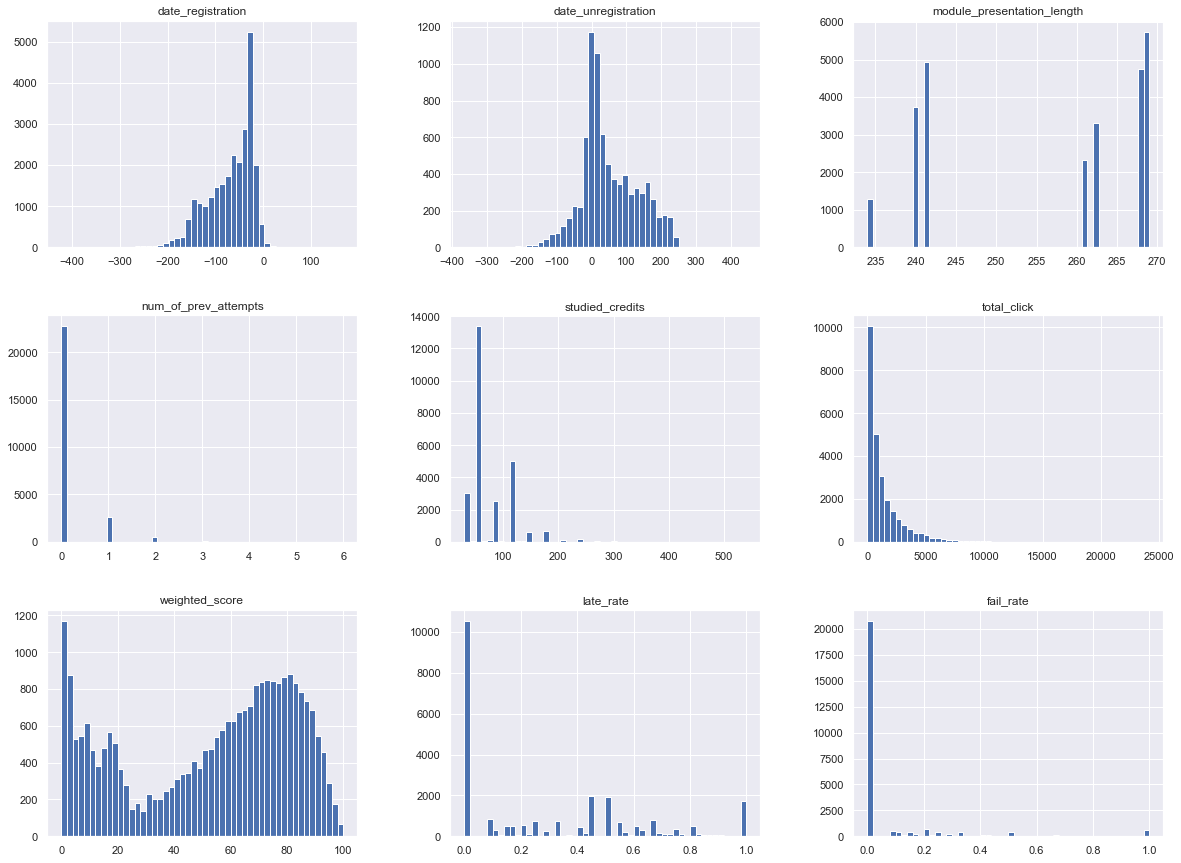

In [133]:
train.hist(bins=50, figsize=(20,15))
plt.show()

There's a lot of skewed variables in this dataset. Something to keep in mind when using linear models as these assume normal distributions.

## Target variable - weighted score

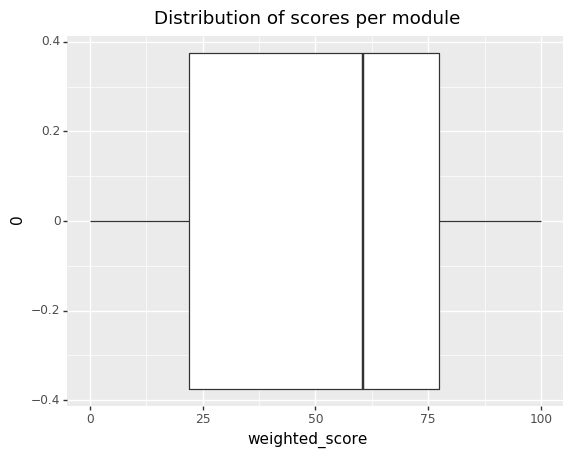

<ggplot: (8763626591761)>

In [134]:
(
    ggplot(train)
    + aes(x=0, y='weighted_score')
    + geom_boxplot(outlier_color='crimson')
    + ggtitle("Distribution of scores per module")
    + coord_flip()
)

We can see the target variable has two peaks and is not normally distributed, but it doesn't have any outliers. We may wish to transform the target at some point to improve our models. This notebook shows very basic analysis though, so we will not be doing this, but it's something to keep in mind when using certain models (like the linear regression that assumes the distributions are normal).

## Correlation matrix

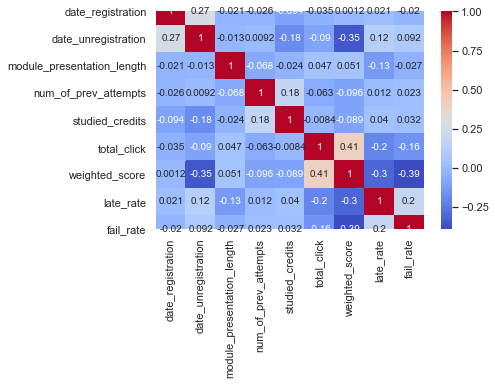

In [135]:
# Let's make a correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", );

This can show us that there is little colinearity among the variables. Let's have a closer look at linear correlations between features and the target.

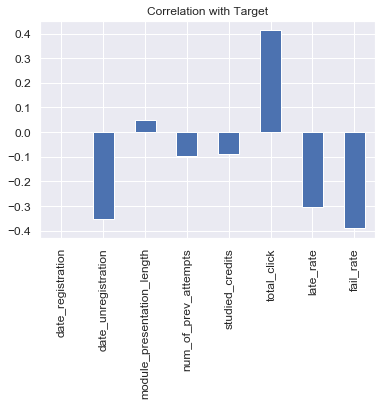

In [136]:
train\
.drop(columns=['weighted_score'])\
.corrwith(train['weighted_score']).plot.bar(
        figsize = (6, 4), title = "Correlation with Target", fontsize = 12,
        rot = 90, grid = True);

Let's look at the numbers for this: 

In [137]:
train.corrwith(train['weighted_score']).sort_values(ascending=False)

weighted_score                1.000000
total_click                   0.412264
module_presentation_length    0.051036
date_registration             0.001222
studied_credits              -0.089486
num_of_prev_attempts         -0.095649
late_rate                    -0.303480
date_unregistration          -0.351939
fail_rate                    -0.389723
dtype: float64

Immediately we can see weighted_score is most strongly positively correlated with total_click. The more students engaged with Blackboard, the better results they got. Theyre is also weak negative correlation with the number of the previous attempts. Late_rate and fail_rate also negatively correlated with weighted score, albeit weakly.

There's no correlation with module_presentation_length or date_registration, or studied_credits.

<a id="cat"></a>
# 10. Univariate analysis: categorical data
***

In [138]:
# Produce a dataframe with just categorical columns
df_cat = train.select_dtypes(exclude=np.number)

df_cat.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,disability,final_result
16563,DDD,2014B,464685,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,N,Pass
16006,DDD,2013J,606593,M,Scotland,A Level or Equivalent,20-30%,0-35,N,Withdrawn
12884,CCC,2014J,1674799,M,South Region,HE Qualification,70-80%,55<=,N,Pass
27781,FFF,2014J,195246,M,West Midlands Region,Lower Than A Level,10-20,0-35,N,Fail
25125,FFF,2013J,582080,M,South East Region,Lower Than A Level,10-20,35-55,N,Fail


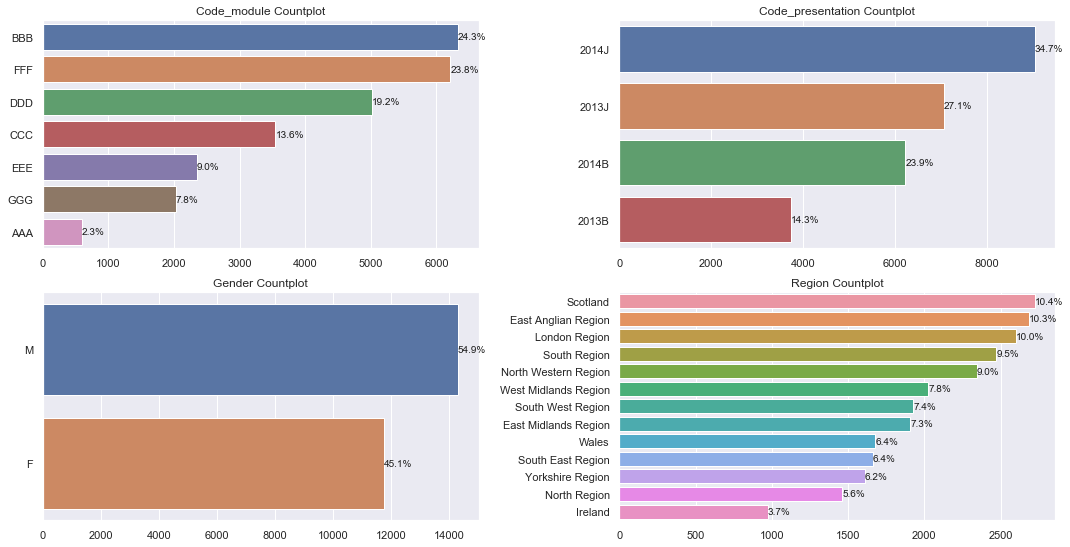

In [139]:
# Set the plot number for the first subplot function
plot_number = 1

# Set sizes for all plots
plt.figure(figsize=(15, 15)) # create a figure object
plt.subplots_adjust(hspace = 0.5) # set the size of subplots

for col in df_cat[['code_module', 'code_presentation', 'gender', 'region']]:
    
    # Call countplot on each column
    plt.subplot(4, 2, plot_number)
    sns.countplot(
        y=col,
        data=df_cat,
        order=df_cat[col].value_counts().index
    )
    plt.title(f'{col.capitalize()} Countplot')
    plt.xlabel('')
    plt.ylabel('')

    plot_number = plot_number + 1 # set a new plot number for the next subplot function
    
    # Add relative frequency labels:
    n_points = df_cat.shape[0]
    col_counts = df_cat[col].value_counts()
    locs, labels = plt.yticks()   # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):

        # get the text property for the label to get the correct count
        count = col_counts[label.get_text()]
        pct_string = '{:0.1f}%'.format(100*count/n_points)

        # print the annotation at the top of the bar
        plt.text(x=count, y=loc, s=pct_string, ha='left', va='center', color='k')
    
plt.tight_layout()

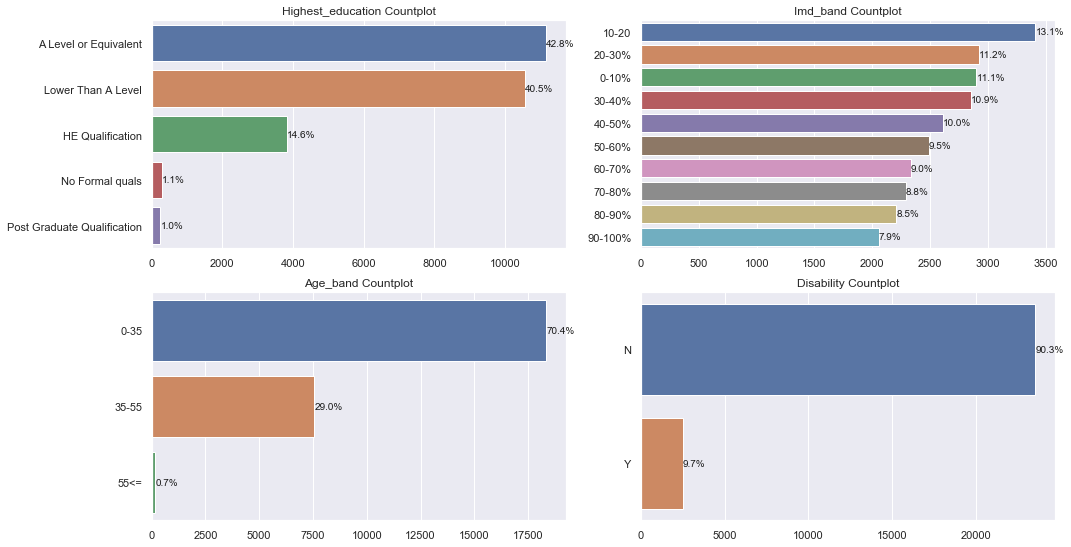

In [140]:
# Set the plot number for the first subplot function
plot_number = 1

# Set sizes for all plots
plt.figure(figsize=(15, 15)) # create a figure object
plt.subplots_adjust(hspace = 0.5) # set the size of subplots

for col in df_cat[['highest_education', 'imd_band', 'age_band', 'disability']]:
    
    # Call countplot on each column
    plt.subplot(4, 2, plot_number)
    sns.countplot(
        y=col,
        data=df_cat,
        order=df_cat[col].value_counts().index
    )
    plt.title(f'{col.capitalize()} Countplot')
    plt.xlabel('')
    plt.ylabel('')

    plot_number = plot_number + 1 # set a new plot number for the next subplot function
    
    # Add relative frequency labels:
    n_points = df_cat.shape[0]
    col_counts = df_cat[col].value_counts()
    locs, labels = plt.yticks()   # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc, label in zip(locs, labels):

        # get the text property for the label to get the correct count
        count = col_counts[label.get_text()]
        pct_string = '{:0.1f}%'.format(100*count/n_points)

        # print the annotation at the top of the bar
        plt.text(x=count, y=loc, s=pct_string, ha='left', va='center', color='k')
    
plt.tight_layout()

* Very few students with no formal education (1%)
* Very few students with post-grad qualifications.

These two categories should be merged with 'Lower Than A Level' and 'HE Qualification', respectivelly, as with so little data these two categories are not likely to bring much insight.

## Change education categories

In [141]:
# Rename 'no formal quals' into 'lower than a level'
train['highest_education'] = np.where( (train['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           train['highest_education']
                                    )

# Rename post-grads
train['highest_education'] = np.where( (train['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           train['highest_education']
                                    )


# Do the same for the test set
test['highest_education'] = np.where( (test['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           test['highest_education']
                                    )

test['highest_education'] = np.where( (test['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           test['highest_education']
                                    )

## Change age categories

Same can be done for the age bands, merging 35-55 and 55+ groups into one. First, let's have a closer look at this variable.

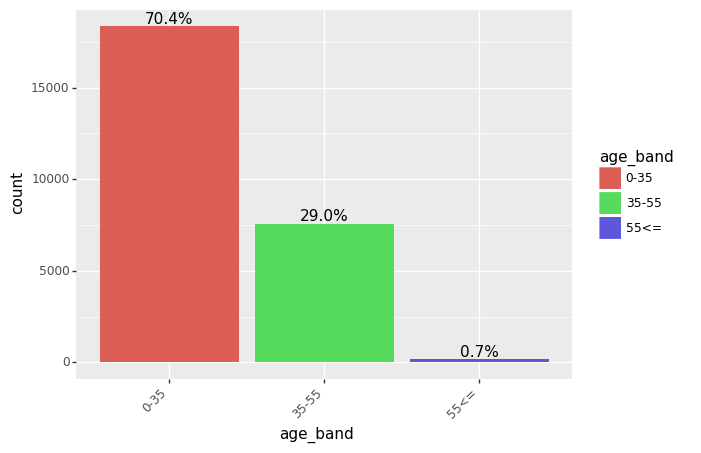

<ggplot: (8763626333701)>

In [142]:
# Have a closer look at the category
(
    ggplot(train)
    + aes(x='age_band', fill='age_band')
    + geom_bar()
    + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

Now let's merge the least frequent categories.

In [143]:
# Replace 55+ and 35-55 groups with 35+
train['age_band'] = np.where( (train['age_band'] == '55<='),
                                           '35+',
                                           train['age_band']
                                    )

train['age_band'] = np.where( (train['age_band'] == '35-55'),
                                           '35+',
                                           train['age_band']
                                    )

# Do the same for the test set
test['age_band'] = np.where( (test['age_band'] == '55<='),
                                           '35+',
                                           test['age_band']
                                    )

test['age_band'] = np.where( (test['age_band'] == '35-55'),
                                           '35+',
                                           test['age_band']
                                    )

Let's see what our count plot for the age variable looks like after merging the categories.

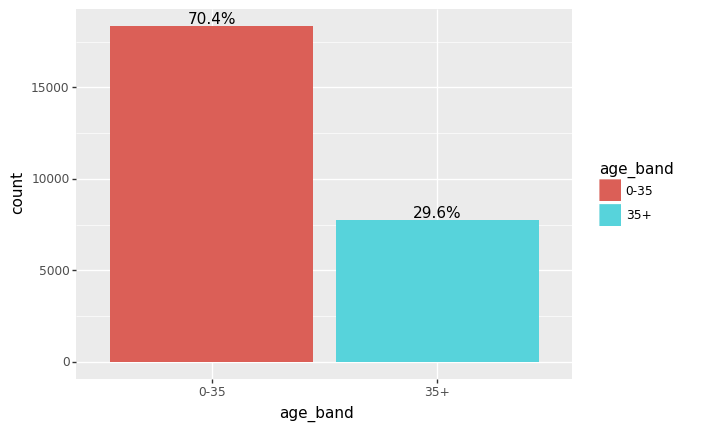

<ggplot: (8763603689157)>

In [144]:
# See the changes
(
    ggplot(train)
    + aes(x='age_band', fill='age_band')
    + geom_bar()
    + geom_text(
     aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )
)

<a id="scores-vs-variables"></a>
# 11. Bivariate analysis: final scores vs other variables
***

## Numerical

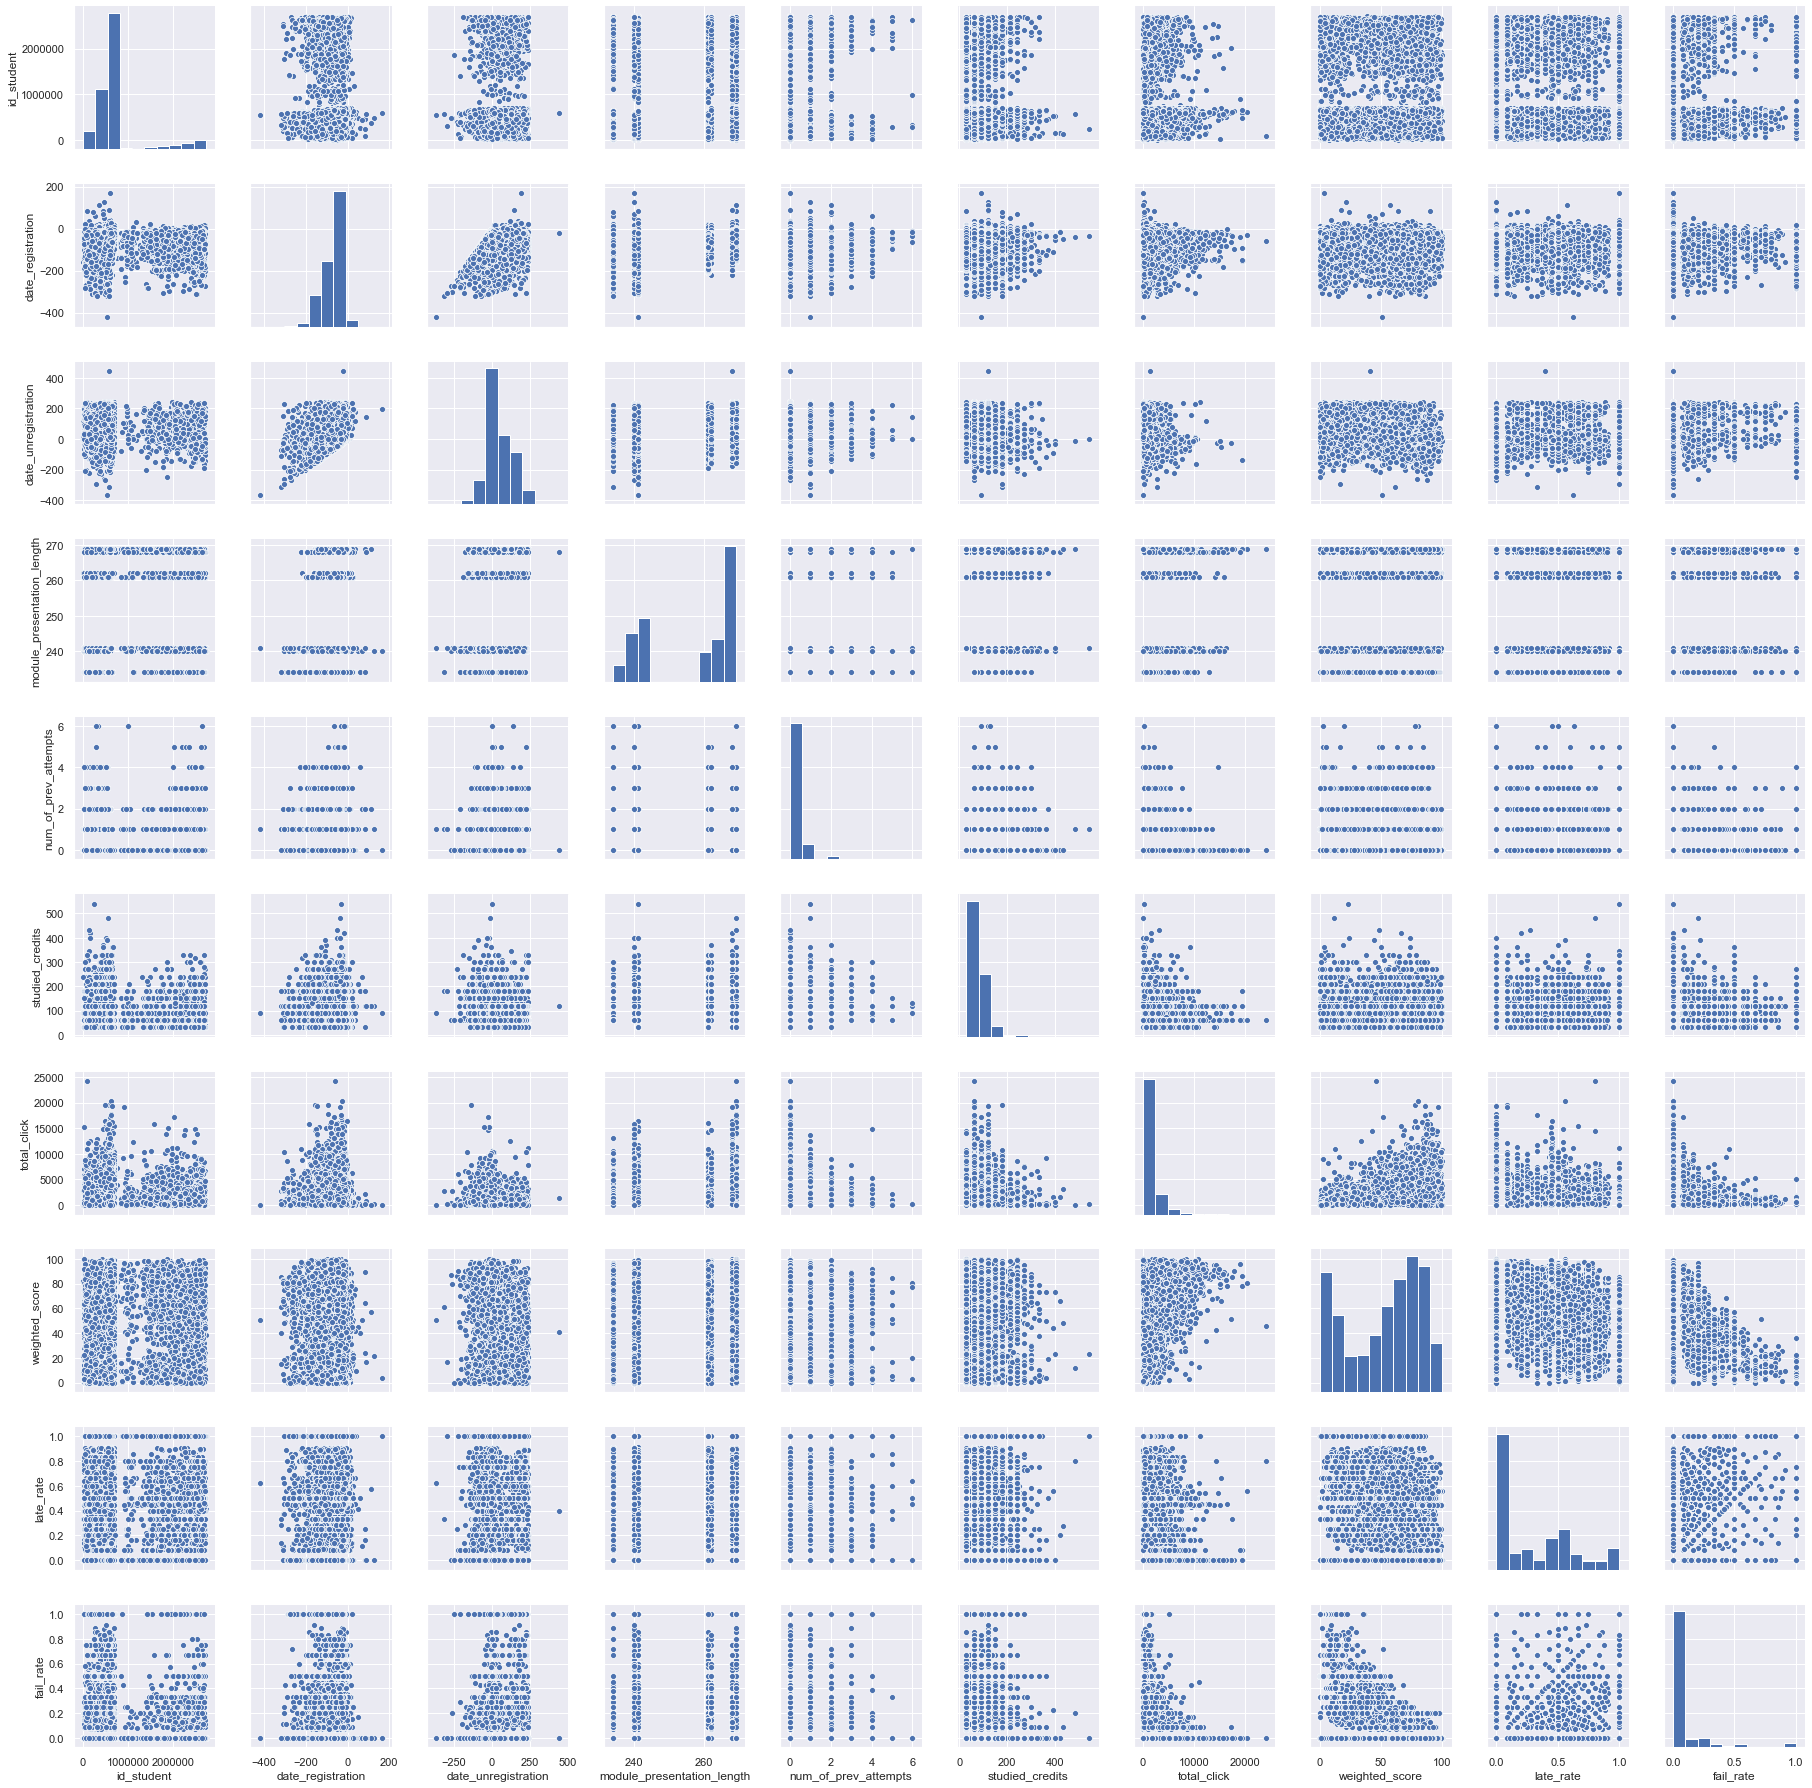

In [145]:
sns.pairplot(train)

The results are vague. There doesn't seem to be any strong relationships between any variables and the target expect, perhaps, the number of total clicks.

## Categorical

Let's make a helper column to indicate if the student failed or not so we can compare categorical variables for failed and passing students.

In [146]:
fail_final=train['weighted_score'] < 40
train = train.assign(fail_final=train['weighted_score'] < 40)

train.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click,weighted_score,late_rate,fail_rate,fail_final
16563,DDD,2014B,464685,-36.0,NaN,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,Pass,1694.0,64.9125,0.142857,0.0,False
16006,DDD,2013J,606593,-32.0,122.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,Withdrawn,692.0,14.8625,0.000000,0.0,True
12884,CCC,2014J,1674799,-21.0,NaN,269,M,South Region,HE Qualification,70-80%,35+,0,60,N,Pass,1963.0,61.4300,0.750000,0.0,False
27781,FFF,2014J,195246,-124.0,NaN,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,Fail,2138.0,39.5000,0.181818,0.0,True
25125,FFF,2013J,582080,-114.0,NaN,268,M,South East Region,Lower Than A Level,10-20,35+,0,60,N,Fail,188.0,9.2500,0.000000,0.0,True


### code_module

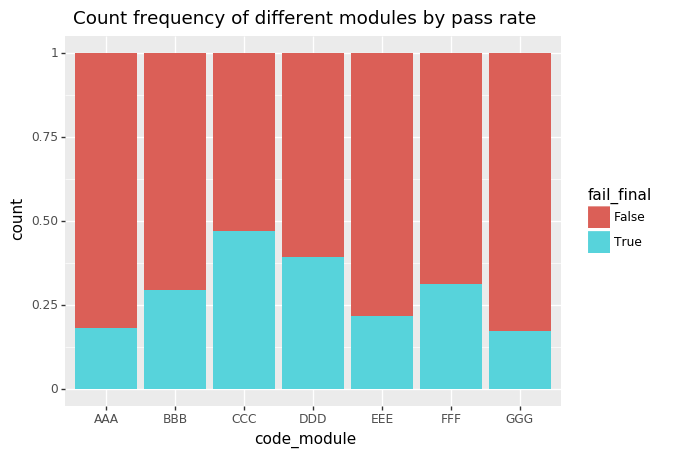

<ggplot: (8763626591189)>

In [147]:
(
    ggplot(train)
    + aes(x='code_module', fill='fail_final')
    + geom_bar(position='fill')
    + ggtitle("Count frequency of different modules by pass rate")
)

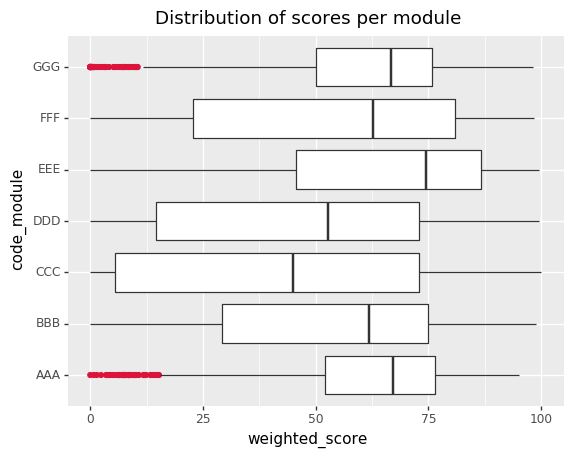

<ggplot: (8763632241825)>

In [148]:
(
    ggplot(train)
    + aes('code_module', 'weighted_score')
    + geom_boxplot(outlier_color='crimson')
    + ggtitle("Distribution of scores per module")
    + coord_flip()
)

It seems that some modules have higher fail rates than others. For example, for module CCC the pass rate is just a little over 50%. The boxplot also reveals some outliers.

### code_presentation

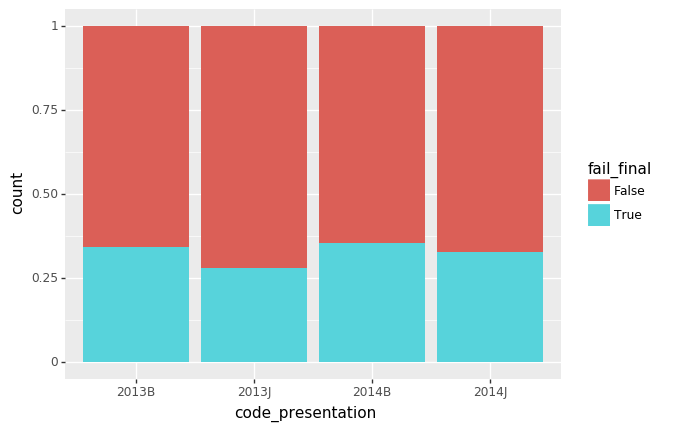

<ggplot: (8763634029573)>

In [149]:
(
    ggplot(train)
    + aes(x='code_presentation', fill='fail_final')
    + geom_bar(position='fill')
)

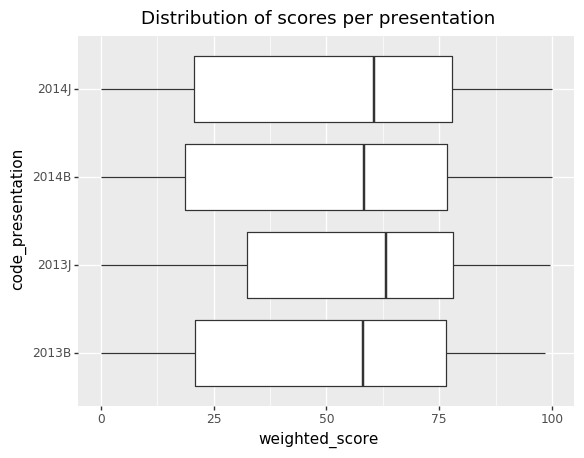

<ggplot: (8763634166641)>

In [150]:
(
    ggplot(train)
    + aes('code_presentation', 'weighted_score')
    + geom_boxplot(outlier_color='crimson')
    + ggtitle("Distribution of scores per presentation")
    + coord_flip()
)

Module presentation (semester) seems to have no effect on the pass/fail rate.

### gender

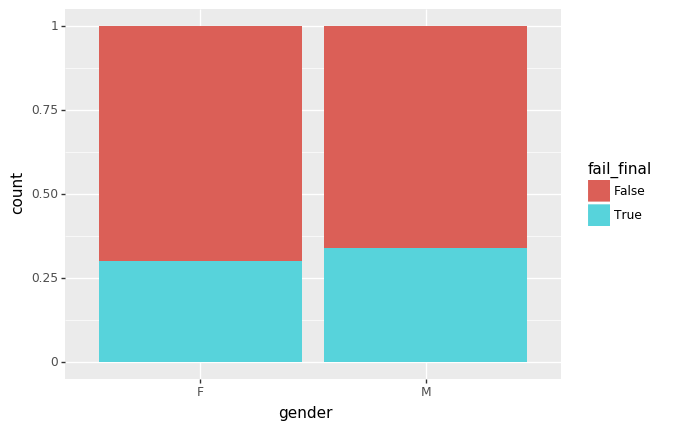

<ggplot: (8763629994473)>

In [151]:
(
    ggplot(train)
    + aes(x='gender', fill='fail_final')
    + geom_bar(position='fill')
)

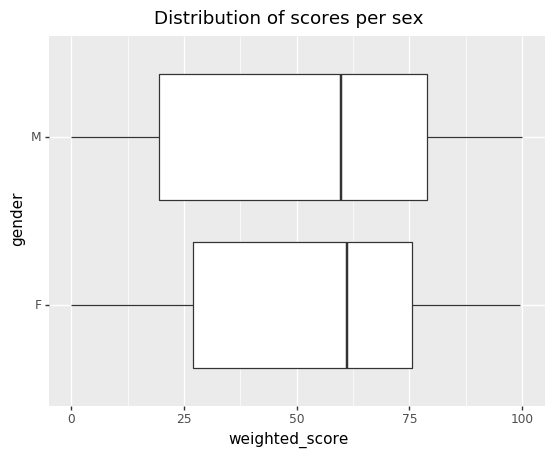

<ggplot: (8763629984705)>

In [152]:
(
    ggplot(train)
    + aes('gender', 'weighted_score')
    + geom_boxplot(outlier_color='crimson')
    + ggtitle("Distribution of scores per sex")
    + coord_flip()
)

Again, there's not much difference between men and women passing or failing modules.

### region

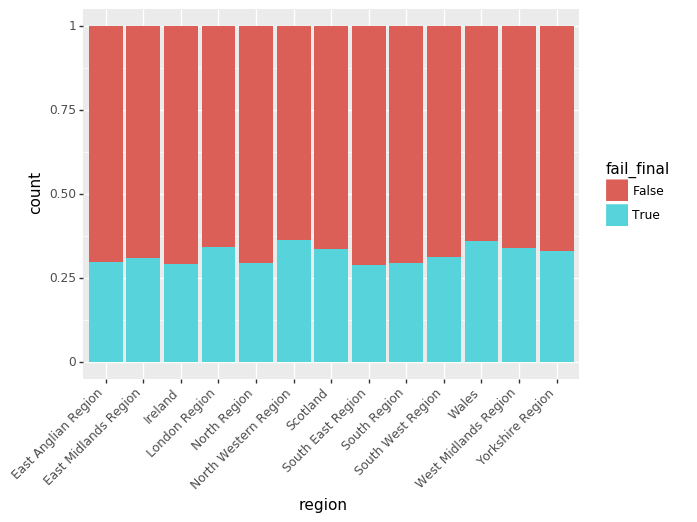

<ggplot: (8763634551029)>

In [153]:
(
    ggplot(train)
    + aes(x='region', fill='fail_final')
    + geom_bar(position='fill')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

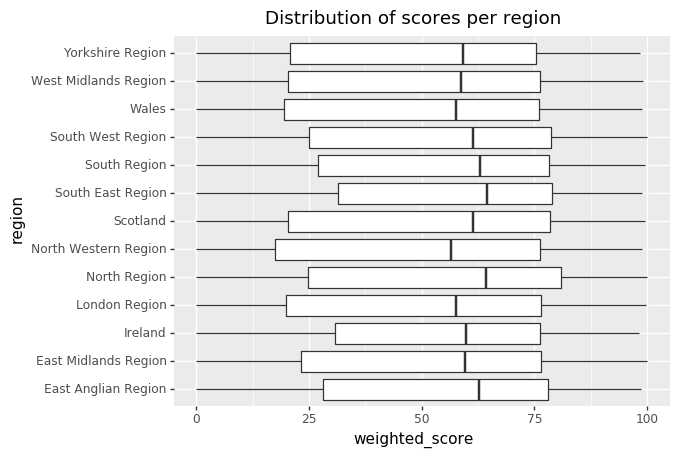

<ggplot: (8763633773325)>

In [154]:
(
    ggplot(train)
    + aes('region', 'weighted_score')
    + geom_boxplot(outlier_color='crimson')
    + ggtitle("Distribution of scores per region")
    + coord_flip()
)

There is very little difference in pass rates between regions.

### highest_education

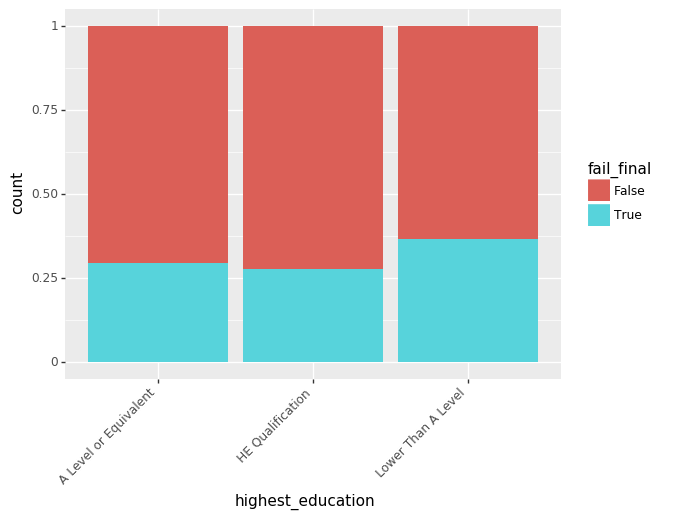

<ggplot: (8763632916961)>

In [155]:
(
    ggplot(train)
    + aes(x='highest_education', fill='fail_final')
    + geom_bar(position='fill')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

Students that have lower than A level previous education seem to fail more, however, the difference is so slight it may not be statistically significant.

### imd_band

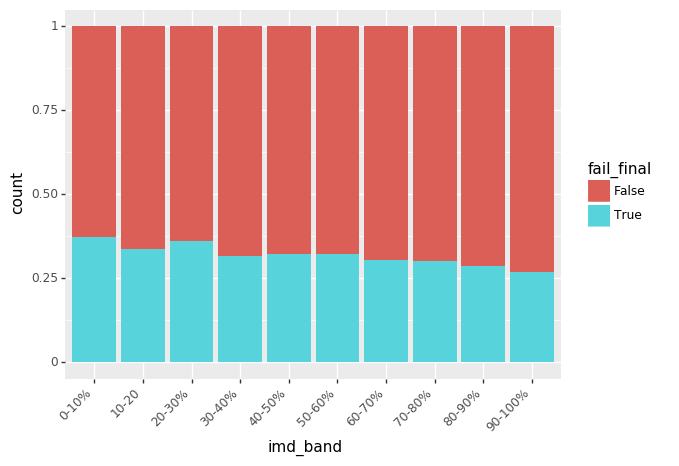

<ggplot: (8763634865141)>

In [156]:
(
    ggplot(train)
    + aes(x='imd_band', fill='fail_final')
    + geom_bar(position='fill')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

Very little difference in pass rates amongst students in different deprivation bands, but there does seem to be a trend - the more deprived the area is, the higher the fail rate. 0-10% IMD means the student lives in an area that that falls amongst top 0-10% most deprived small areas (the higher the percentage, the more deprived the area).

### age_band

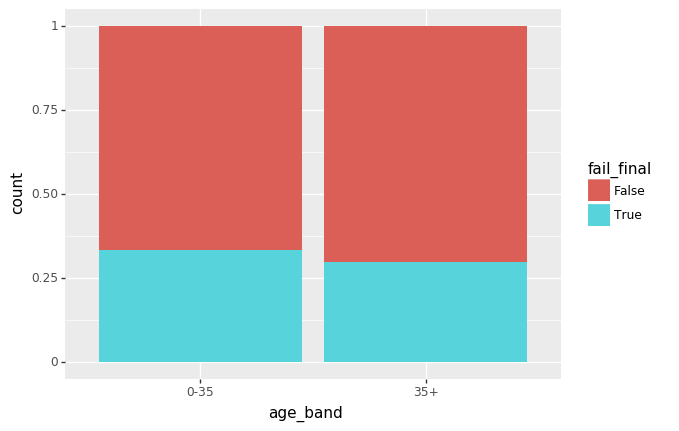

<ggplot: (8763632921589)>

In [157]:
(
    ggplot(train)
    + aes(x='age_band', fill='fail_final')
    + geom_bar(position='fill')
)

Older people seem to do bettwer academically, however, the difference is fairly small.

### disability

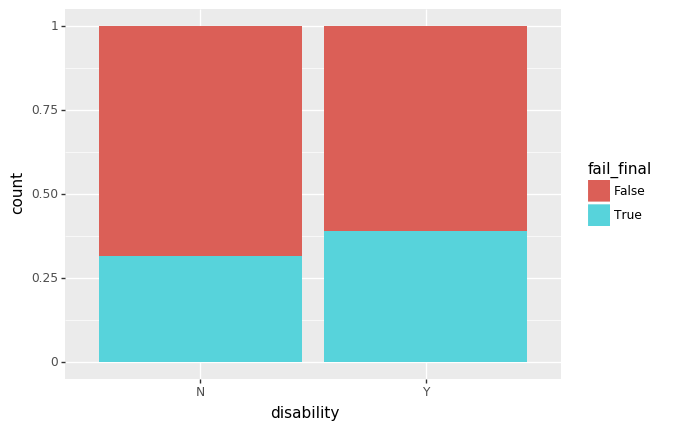

<ggplot: (8763635285921)>

In [158]:
(
    ggplot(train)
    + aes(x='disability', fill='fail_final')
    + geom_bar(position='fill')
)

As expected, people with disabilities do worse academically. This is to be expected as disabled students would face more challenges due to ill health.

<a id="classification"></a>
# 12. Classification
***

Next, we approach the task as a classification problem. Model is prepared with last cleaning steps, then categorical values are encoded, models are fitted and then evaluated.

## 12.1 Model preparation

In [159]:
train = train_class.copy()
test = test_class.copy()

train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_click
16563,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,Pass,1694.0
16006,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,Withdrawn,692.0
12884,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,55<=,0,60,N,Pass,1963.0
27781,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,Fail,2138.0
25125,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35-55,0,60,N,Fail,188.0


### Last cleaning

In [160]:
# Distinction as a Pass
train['final_result'] = np.where( (train['final_result'] == 'Distinction'),
                                           'Pass',
                                           train['final_result']
                                    )
# Withdrawn as a Fail (to make the target binary)
train['final_result'] = np.where( (train['final_result'] == 'Withdrawn'),
                                           'Fail',
                                           train['final_result']
                                    )
# Same for test set
test['final_result'] = np.where( (test['final_result'] == 'Distinction'),
                                           'Pass',
                                           test['final_result']
                                    )
test['final_result'] = np.where( (test['final_result'] == 'Withdrawn'),
                                           'Fail',
                                           test['final_result']
                                    )

In [161]:
# Rename 'no formal quals' into 'lower than a level'
train['highest_education'] = np.where( (train['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           train['highest_education']
                                    )

# Rename post-grads
train['highest_education'] = np.where( (train['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           train['highest_education']
                                    )


# Do the same for the test set
test['highest_education'] = np.where( (test['highest_education'] == 'No Formal quals'),
                                           'Lower Than A Level',
                                           test['highest_education']
                                    )

test['highest_education'] = np.where( (test['highest_education'] == 'Post Graduate Qualification'),
                                           'HE Qualification',
                                           test['highest_education']
                                    )
### Age bands ###
train['age_band'] = np.where( (train['age_band'] == '55<='),
                                           '35-55',
                                           train['age_band']
                                    )

train['age_band'] = np.where( (train['age_band'] == '35-55'),
                                           '35+',
                                           train['age_band']
                                    )

# Do the same for the test set
test['age_band'] = np.where( (test['age_band'] == '55<='),
                                           '35-55',
                                           test['age_band']
                                    )

test['age_band'] = np.where( (test['age_band'] == '35-55'),
                                           '35+',
                                           test['age_band']
                                    )

In [162]:
# Separate features from target

'''Training set'''
# Drop target column
X_train = train.drop(columns=['final_result'])
# Make an array with target
Y_train = train['final_result'].copy()

'''Test set'''
# Drop target column
X_test = test.drop(columns=['final_result'])
# Make an array with target
Y_test = test['final_result'].copy()

X_train.head()

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click
16563,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,1694.0
16006,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,692.0
12884,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,35+,0,60,N,1963.0
27781,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,2138.0
25125,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35+,0,60,N,188.0


In [163]:
X_train.shape

(26074, 13)

### Encoding for trees

Encoding for tree models does not require scaling.    

In [164]:
# Set encoding and scaling instructions
column_transform = make_column_transformer(
    (OrdinalEncoder(), ['code_module', 'code_presentation', 'gender', 'region', 'disability',\
                        'highest_education', 'imd_band', 'age_band']),
    remainder='passthrough'
)

# Apply column transformer to features
X_encoded = column_transform.fit_transform(X_train)

In [165]:
pd.DataFrame(X_encoded).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,-36.0,241.0,1.0,70.0,1694.0
1,3.0,1.0,1.0,6.0,0.0,0.0,2.0,0.0,-32.0,261.0,0.0,120.0,692.0
2,2.0,3.0,1.0,8.0,0.0,1.0,7.0,1.0,-21.0,269.0,0.0,60.0,1963.0
3,5.0,3.0,1.0,11.0,0.0,2.0,1.0,0.0,-124.0,269.0,0.0,60.0,2138.0
4,5.0,1.0,1.0,7.0,0.0,2.0,1.0,1.0,-114.0,268.0,0.0,60.0,188.0


## 12.2. Models:

In [166]:
def display_accuracy_scores(pipeline, X, Y):
    scores = cross_val_score(pipeline, X, Y, cv=5, scoring='accuracy')
    print('Scores\t:', scores)
    print('Mean\t:', scores.mean())
    print('SD\t:', scores.std())

### Decision Tree

In [167]:
dt = DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=10, max_features=8)

dt_pipeline = make_pipeline(column_transform, dt)


### Cross-validate ###
# Train set
print('Evaluation of the training set')
display_accuracy_scores(dt_pipeline, X_train, Y_train)

Evaluation of the training set
Scores	: [0.75953979 0.7641419  0.76337488 0.75896453 0.75872651]
Mean	: 0.7609495197125814
SD	: 0.002321335372179675


### GradientBoostingClassifier

In [168]:
gb = GradientBoostingClassifier(min_samples_leaf=15, min_samples_split=10, max_features=8)

gb_pipeline = make_pipeline(column_transform, gb)


### Cross-validate ###
# Train set
print('Evaluation of the training set')
display_accuracy_scores(gb_pipeline, X_train, Y_train)

Evaluation of the training set
Scores	: [0.78600192 0.79309684 0.78964525 0.78657718 0.79516686]
Mean	: 0.7900976094672467
SD	: 0.0035795356757768403


### Random Forest

In [169]:
rf = RandomForestClassifier(min_samples_leaf=15, min_samples_split=10,
                                max_features=8, n_estimators=20)

rf_pipeline = make_pipeline(column_transform, rf)

### Cross-validate ###
# Train set
print('Evaluation of the training set')
display_accuracy_scores(rf_pipeline, X_train, Y_train)

Evaluation of the training set
Scores	: [0.78772771 0.78427613 0.78600192 0.78082454 0.78941312]
Mean	: 0.7856486831493203
SD	: 0.002958861919795733


### XGBoost

In [170]:
xgb = XGBClassifier(min_samples_leaf=15, min_samples_split=10,
                                max_features=8, n_estimators=20)

xgb_pipeline = make_pipeline(column_transform, xgb)

### Cross-validate ###
# Train set
print('Evaluation of the training set')
display_accuracy_scores(xgb_pipeline, X_train, Y_train)

Evaluation of the training set
Scores	: [0.76951103 0.77085331 0.76548418 0.76395014 0.77713847]
Mean	: 0.7693874262118252
SD	: 0.004626925244835193


### CatBoost

In [171]:
cb = CatBoostClassifier(
        iterations=100,
        learning_rate = 0.1,
        random_strength = 0.1,
        depth = 8,
        loss_function = 'MultiClass',
        eval_metric = 'AUC',
        leaf_estimation_method = 'Newton'
)

cb_pipeline = make_pipeline(column_transform, cb)

### Cross-validate ###
# Train set
print('Evaluation of the training set')
display_accuracy_scores(cb_pipeline, X_train, Y_train)

Evaluation of the training set
0:	total: 77ms	remaining: 7.63s
1:	total: 95.9ms	remaining: 4.7s
2:	total: 110ms	remaining: 3.54s
3:	total: 127ms	remaining: 3.06s
4:	total: 146ms	remaining: 2.77s
5:	total: 165ms	remaining: 2.58s
6:	total: 182ms	remaining: 2.42s
7:	total: 197ms	remaining: 2.26s
8:	total: 210ms	remaining: 2.13s
9:	total: 223ms	remaining: 2.01s
10:	total: 236ms	remaining: 1.91s
11:	total: 244ms	remaining: 1.79s
12:	total: 253ms	remaining: 1.69s
13:	total: 261ms	remaining: 1.6s
14:	total: 269ms	remaining: 1.52s
15:	total: 278ms	remaining: 1.46s
16:	total: 291ms	remaining: 1.42s
17:	total: 304ms	remaining: 1.39s
18:	total: 316ms	remaining: 1.35s
19:	total: 328ms	remaining: 1.31s
20:	total: 347ms	remaining: 1.3s
21:	total: 362ms	remaining: 1.28s
22:	total: 386ms	remaining: 1.29s
23:	total: 403ms	remaining: 1.27s
24:	total: 419ms	remaining: 1.26s
25:	total: 435ms	remaining: 1.24s
26:	total: 449ms	remaining: 1.21s
27:	total: 467ms	remaining: 1.2s
28:	total: 488ms	remaining: 1.2

49:	total: 405ms	remaining: 405ms
50:	total: 420ms	remaining: 403ms
51:	total: 432ms	remaining: 399ms
52:	total: 446ms	remaining: 396ms
53:	total: 458ms	remaining: 390ms
54:	total: 467ms	remaining: 382ms
55:	total: 474ms	remaining: 373ms
56:	total: 482ms	remaining: 364ms
57:	total: 490ms	remaining: 355ms
58:	total: 498ms	remaining: 346ms
59:	total: 506ms	remaining: 337ms
60:	total: 514ms	remaining: 328ms
61:	total: 522ms	remaining: 320ms
62:	total: 529ms	remaining: 311ms
63:	total: 538ms	remaining: 302ms
64:	total: 546ms	remaining: 294ms
65:	total: 553ms	remaining: 285ms
66:	total: 561ms	remaining: 276ms
67:	total: 568ms	remaining: 267ms
68:	total: 576ms	remaining: 259ms
69:	total: 584ms	remaining: 250ms
70:	total: 591ms	remaining: 241ms
71:	total: 599ms	remaining: 233ms
72:	total: 612ms	remaining: 226ms
73:	total: 627ms	remaining: 220ms
74:	total: 640ms	remaining: 213ms
75:	total: 652ms	remaining: 206ms
76:	total: 660ms	remaining: 197ms
77:	total: 667ms	remaining: 188ms
78:	total: 674

94:	total: 842ms	remaining: 44.3ms
95:	total: 855ms	remaining: 35.6ms
96:	total: 868ms	remaining: 26.8ms
97:	total: 879ms	remaining: 17.9ms
98:	total: 886ms	remaining: 8.95ms
99:	total: 894ms	remaining: 0us
Scores	: [0.7915628  0.79405561 0.79808245 0.78868648 0.80149597]
Mean	: 0.7947766633162947
SD	: 0.004561064038267273


## 12.3 Best Classification Model - evaluation 

Let's chose the best model. To do this we need to have a look at how the model performed in cross-validation.


**Cross-validation:**

|Models| Mean Acc|SD|
| ----------- | ----------- |-------|
|**DT**|0.761|0.002|
|**GB**|0.79|0.004|
|**RF**|0.786|0.003|
|**XGB**|0.769|0.005|
|**CB**|0.795|0.005|


CatBoost classifier model performed the best. Althrough its accuracy scores (0.795, SD = 0.005) are similar to the GB model (0.79, SD = 0.004), the GB model performs with slightly less variance between the scores during cross-validation as shown by lower standard deviation.

<a id="discussion"></a>
# 13. Discussion
***

The best model for the classification task was a CatBoost classifier (0.795 accuracy score on cross-validation). Again, this is without any hyperparameter tuning.

Next steps to take would be to find which features are most important and which can be dropped. Hyperparameter tuning can be used to find the best set of parameters for the models. Various dimensionality reduction tools can be used to improve the performance of the models. Another point to make is that accuracy score isn't the best way to evaluate classification models, especially when the target is imbalanced. We have an imbalanced target for this classification problem, so dealing with this imbalance and using a different evaluation metric would be advantageous.

It's possible to engineer some more features too, for example, we know VLE interactions are important for student success, but maybe the type of the resource the student interacts with will be a better signal than total clicks for all resources?